<a href="https://colab.research.google.com/github/nokks/Fairness/blob/main/2021_scipy_tutorial/fairness-in-AI-systems-student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fairness in AI systems: <br>An assessment and mitigation of ML models using Fairlearn and Aequitas fairness toolkits

---
Adapted from
_SciPy 2021 Tutorial: Fairness in AI systems: From social context to practice using Fairlearn by Manojit Nandi, Miroslav Dudík, Triveni Gandhi, Lisa Ibañez, Adrin Jalali, Michael Madaio, Hanna Wallach, Hilde Weerts is licensed under
[CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)._

---

Fairness in AI systems is an interdisciplinary field of research and practice that aims to understand and address some of the negative impacts of AI systems on society. The Notebook shows the process of assessing and mitigating fairness-related harms in the context of the U.S. criminal justice system. We use the Fairlearn and Aequitas libraries to assess ML models for performance disparities across different racial groups and mitigate those disparities using the Threshold optimiser algorithmic technique.

# **Prepare environment**

## Install packages

In [ ]:
!pip install --upgrade fairlearn==0.7.0
!pip install --upgrade scikit-learn
!pip install --upgrade seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.5/177.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.1
    Uninstalling seaborn-0.13.1:
      Successfully uninstalled seaborn-0.13.1


## Import and set up packages

In [ ]:
import numpy as np
import pandas as pd

pd.set_option("display.float_format", "{:.3f}".format)

In [ ]:
# visualisation packages

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [ ]:
!pip install -U setuptools==70.2.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 11.1 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 71.0.4
    Uninstalling setuptools-71.0.4:
      Successfully uninstalled setuptools-71.0.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


In [ ]:
# Aequitas is a fairness library
!pip install aequitas

In [ ]:
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
!pip install sklearn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import Bunch
from sklearn.metrics import (
    balanced_accuracy_score,
    roc_auc_score,
    accuracy_score,
    recall_score,
    confusion_matrix,
    roc_curve,
    RocCurveDisplay,
    ConfusionMatrixDisplay)
from sklearn import set_config

set_config(display="diagram")

In [ ]:
from fairlearn.metrics import (
    MetricFrame,
    true_positive_rate,
    false_positive_rate,
    false_negative_rate,
    selection_rate,
    count,
    false_negative_rate_difference
)

from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.postprocessing._interpolated_thresholder import InterpolatedThresholder
from fairlearn.postprocessing._threshold_operation import ThresholdOperation
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds, TruePositiveRateParity

In [ ]:
from IPython import display
from datetime import date

# **Overview of fairness in AI systems**

# **Introduction of Fairlearn and other resources**


This tutorial builds on the following open source projects:

* **machine learning and data processing**: _scikit-learn_, _pandas_, _numpy_
* **plotting**: _seaborn_, _matplotlib_
* **AI fairness**: _Fairlearn_, _Aequitas_

### [Fairlearn](https://fairlearn.org)

Fairlearn is an open-source, community-driven project to help data scientists improve fairness of AI systems. It includes:

* A Python library for fairness assessment and improvement (fairness metrics, mitigation algorithms, plotting, etc.)

* Educational resources covering organizational and technical processes for unfairness mitigation (user guide, case studies, Jupyter notebooks, etc.)

The project was started in 2018 at Microsoft Research. In 2021 it adopted neutral governance structure and since then it is completely community-driven.

### [Aequitas](https://dssg.github.io/aequitas/30_seconds_aequitas.html)

Aequitas is an open source bias-audit library that is used to evaluate model performance across several bias and fairness metrics.

Aequitas will help you:

Understand where biases exist in your model(s)

Compare the level of bias between groups in your sample population (bias disparity)

Visualize absolute bias metrics and their related disparities for rapid comprehension and decision-making.

# **Introduction to the recidivism, likelihood to reoffend scenario**

Our scenario builds on previous research by ProPublica that highlighted racial disparities in the accuracy of the recidivism scores in the U.S criminal justice system. ([Larson et al., 2016](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing)).
Motivated by that work, in this research we wil evaluate the fairness in the COMPAS algorithm used to score recidivism.

**Convenience restriction**

* In practice, the modeling of recidivism would use large data sets covering a wide range of scores. In this study, we work with a [publicly available dataset](https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv) that focuses on recidivism scoring in defendants in Broward county, Florida over 2 years. 2013 and 2014.

## Dataset and task

We will be working with a recidivism scores [dataset](https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv) over a two-year period (2013-2014). Each record represents a defendant's details related to their arrests, this includes personal details, priors count, recid score, etc.

The features describing each defendant include demographics, gender, age, race, juvenile felony count and misdemeanor count, decile score, count of days in jail, charge_degree, is_recid score, is_violent_recid score.

We develop a classification model, which predicts whether a defendant is likely to recid or not this can be used to determine their decile score. The prediction will determine the defendant's risk of recidivism.

**Decision point: Task definition**

* A high decile score can be viewed as a proxy that the defendant will reoffend within 2 years of release.

* We measure model performance via **balanced accuracy**. Another key performance consideration is how many defendants are scored as recidivists, metric we refer to as **selection rate**.



## Fairness considerations

* _Which groups are most likely to be disproportionately negatively affected?_ Previous work suggests that different race and ethnicity groups can be differently affected.

* _What are the harms?_ The key harms here are quality-of-service harms. In particular, false positives, i.e., do not keep in jail someone who is unlikely to reoffend.

* _How should we measure those harms?_


Next steps:
* First examine the dataset and our choice of label with an eye towards a variety of fairness issues.
* Then train a logistic regression model and a CategoricalNB model
* Assess the model performance as well as fairness.
* Finally, use the Threshold Optimiser, an unfairness mitigation strategy to mitigate bias in the model outcomes.


## Fairness-related harms

* How can we determine which type of harm is relevant in a particular scenario?
* What are ways to find out which (groups of) individuals are most likely to be disproportionately negatively affected?


# Task definition and dataset characteristics

Two critical decisions when desiging an AI system are
1. how we define the machine learning task
2. what dataset we use to train our models

These choices are often intertwined, because the dataset is often a convenience dataset, based on availability, which leads to a specific choice of label and performance metric (that's also the case in our scenario).

In this part we load the dataset, and then we examine it for a variety of fairness issues:
1. sample sizes of different demographic groups, and in particular different racial groups
2. appropriateness of our choice of label (two_year_recid)
3. representativeness/informativeness of different features for different groups

Besides dataset characteristics, one additional aspect of dataset fairness is whether the data was collected in a manner that respects the autonomy of individuals in the dataset.




## Load the dataset


We next load the dataset and review the meaning of its columns.


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving compas-scores-two-years-clean.csv to compas-scores-two-years-clean.csv


In [ ]:
# df = pd.read_csv("https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv") was cleaned to reduce the features
# used in training the model.

df = pd.read_csv('compas-scores-two-years-clean.csv')

In [ ]:
df.head()

,sex,age,age_cat,race,juv_fel_count,g_decile_score,juv_misd_count,juv_other_count,c_jail_days,c_days_from_compas,...,is_violent_recid,decile_score,score_text,v_decile_score,v_score_text,priors_count,start,end,event,two_year_recid
0,Male,69,Greater than 45,Other,0,1,0,0,1,1.000,...,0,1,Low,1,Low,0,0,327,0,0
1,Male,34,25 - 45,African-American,0,3,0,0,10,1.000,...,1,3,Low,1,Low,0,9,159,1,1
2,Male,24,Less than 25,African-American,0,4,0,1,1,1.000,...,0,4,Low,3,Low,4,0,63,0,1
3,Male,23,Less than 25,African-American,0,8,1,0,0,1.000,...,0,8,High,6,Medium,1,0,1174,0,0
4,Male,43,25 - 45,Other,0,1,0,0,0,76.000,...,0,1,Low,1,Low,2,0,1102,0,0


In [ ]:
print(df.shape)

(7214, 22)


In [ ]:
print(df.columns)

Index(['sex', 'age', 'age_cat', 'race', 'juv_fel_count', 'g_decile_score',
       'juv_misd_count', 'juv_other_count', 'c_jail_days',
       'c_days_from_compas', 'c_charge_degree', 'is_recid', 'is_violent_recid',
       'decile_score', 'score_text', 'v_decile_score', 'v_score_text',
       'priors_count', 'start', 'end', 'event', 'two_year_recid'],
      dtype='object')


In [ ]:
print(df.dtypes)

sex                    object
age                     int64
age_cat                object
race                   object
juv_fel_count           int64
g_decile_score          int64
juv_misd_count          int64
juv_other_count         int64
c_jail_days             int64
c_days_from_compas    float64
c_charge_degree        object
is_recid                int64
is_violent_recid        int64
decile_score            int64
score_text             object
v_decile_score          int64
v_score_text           object
priors_count            int64
start                   int64
end                     int64
event                   int64
two_year_recid          int64
dtype: object


In [ ]:
categorical_features = df.select_dtypes(include=['object']).columns
print(categorical_features)

for col in categorical_features:
  df[col] =df[col].astype('category')

Index(['sex', 'age_cat', 'race', 'c_charge_degree', 'score_text',
       'v_score_text'],
      dtype='object')


In [ ]:
# remove missing values for c_days_from_compas column
df['c_days_from_compas'] = df['c_days_from_compas'].replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['c_days_from_compas'])
print(df.shape)

(7192, 22)


In [ ]:
# convert c_days_from_compas float to int64
df["c_days_from_compas"] = df["c_days_from_compas"].astype('int64')

In [ ]:
# check data is in expected types, categorical and int64
print(df.dtypes)

sex                   category
age                      int64
age_cat               category
race                  category
juv_fel_count            int64
g_decile_score           int64
juv_misd_count           int64
juv_other_count          int64
c_jail_days              int64
c_days_from_compas       int64
c_charge_degree       category
is_recid                 int64
is_violent_recid         int64
decile_score             int64
score_text            category
v_decile_score           int64
v_score_text          category
priors_count             int64
start                    int64
end                      int64
event                    int64
two_year_recid           int64
dtype: object


In [ ]:
# check for missing values in the dataset
missing_values = df.isnull().sum()
print(missing_values)


sex                   0
age                   0
age_cat               0
race                  0
juv_fel_count         0
g_decile_score        0
juv_misd_count        0
juv_other_count       0
c_jail_days           0
c_days_from_compas    0
c_charge_degree       0
is_recid              0
is_violent_recid      0
decile_score          0
score_text            0
v_decile_score        0
v_score_text          0
priors_count          0
start                 0
end                   0
event                 0
two_year_recid        0
dtype: int64


In [ ]:
print(df.shape)

(7192, 22)


The columns contain mostly int64 and categorical data.


|features| description|
|---|---|
| race, gender, age | demographic features |
| juv_fel_count,priors_count, juv_misd_count, juv_other_count | previous arrests |
|g_decile_score, decile_score, v_decile_score, mission_source_id | Compas score* |
| is_recid, is_violent_recid | likelihood to reoffend within 2 years |
| two_year_recid | target class |

*COMPAS scores for each defendant ranged from 1 to 10, with ten being the highest risk. Scores 1 to 4 were labeled by COMPAS as “Low”; 5 to 7 were labeled “Medium”; and 8 to 10 were labeled “High.”





In [ ]:
# check counts by racial group
df["race"].value_counts()

,count
race,
African-American,3687
Caucasian,2449
Hispanic,631
Other,376
Asian,32
Native American,17


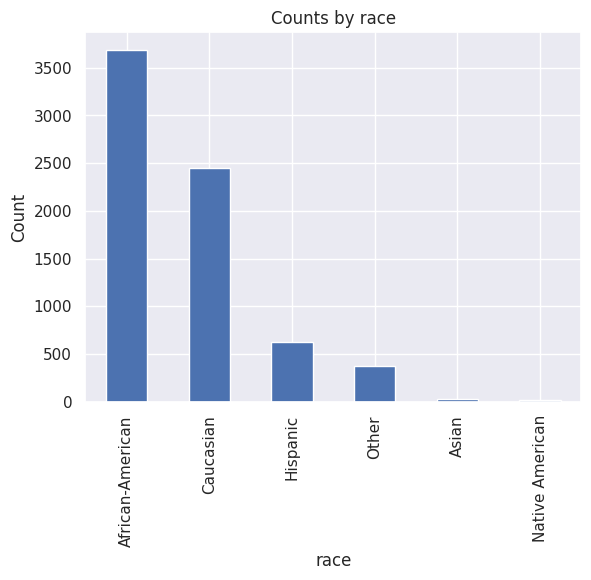

In [ ]:
df["race"].value_counts().plot(kind='bar', rot=90, ylabel='Count', title='Counts by race');

<ipython-input-26-6194346d1e4d>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  race_sex_count = df.groupby(['race', 'sex']).size().reset_index(name='count')


                race     sex  count
0   African-American  Female    648
1   African-American    Male   3039
2              Asian  Female      2
3              Asian    Male     30
4          Caucasian  Female    566
5          Caucasian    Male   1883
6           Hispanic  Female    103
7           Hispanic    Male    528
8    Native American  Female      4
9    Native American    Male     13
10             Other  Female     66
11             Other    Male    310


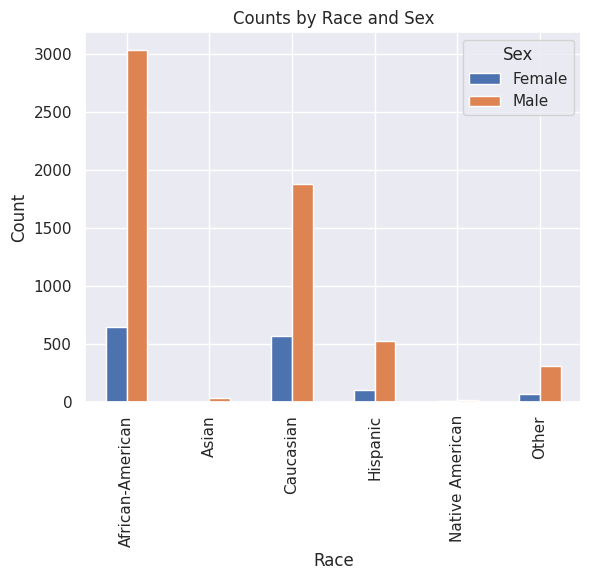

In [ ]:
# Group by race and sex, and count occurrences in each group
race_sex_count = df.groupby(['race', 'sex']).size().reset_index(name='count')

# Display the result
print(race_sex_count)

# Pivot the DataFrame to make plotting easier
pivot_df = race_sex_count.pivot(index='race', columns='sex', values='count')

# Plotting
pivot_df.plot(kind='bar', stacked=False)
plt.title('Counts by Race and Sex')
plt.xlabel('Race')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Sex')
plt.show()

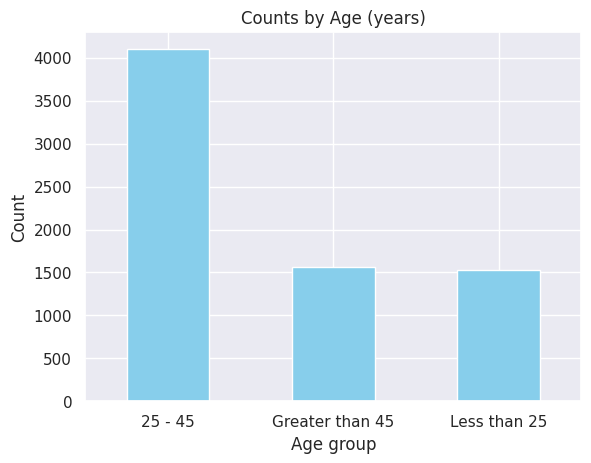

In [ ]:
age_count = df['age_cat'].value_counts().sort_index()

# Plotting
age_count.plot(kind='bar', color='skyblue')
plt.title('Counts by Age (years)')
plt.xlabel('Age group')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

<ipython-input-28-23e789675e68>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  race_age_cat_count = df.groupby(['race', 'age_cat']).size().reset_index(name='count')


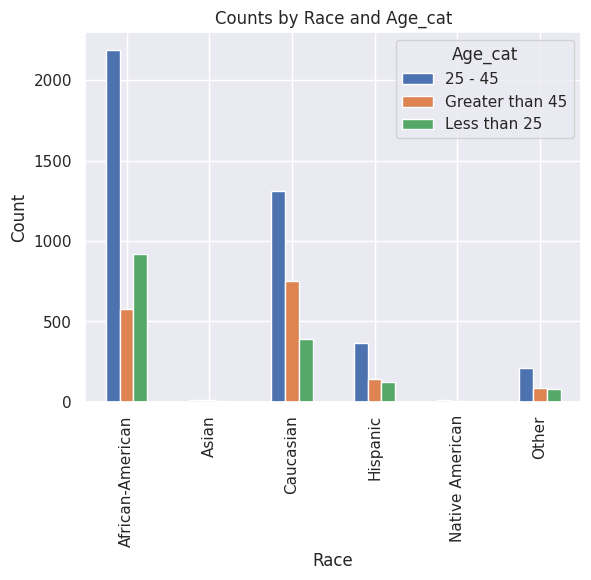

In [ ]:
# Group by race and age_cat, and count occurrences in each group
race_age_cat_count = df.groupby(['race', 'age_cat']).size().reset_index(name='count')

# Pivot the DataFrame to make plotting easier
pivot_df = race_age_cat_count.pivot(index='race', columns='age_cat', values='count')

# Plotting
pivot_df.plot(kind='bar', stacked=False)
plt.title('Counts by Race and Age_cat')
plt.xlabel('Race')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Age_cat')
plt.show()

<ipython-input-29-db44cb7d60fc>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  race_age_cat_count = df.groupby(['race', 'two_year_recid']).size().reset_index(name='count')


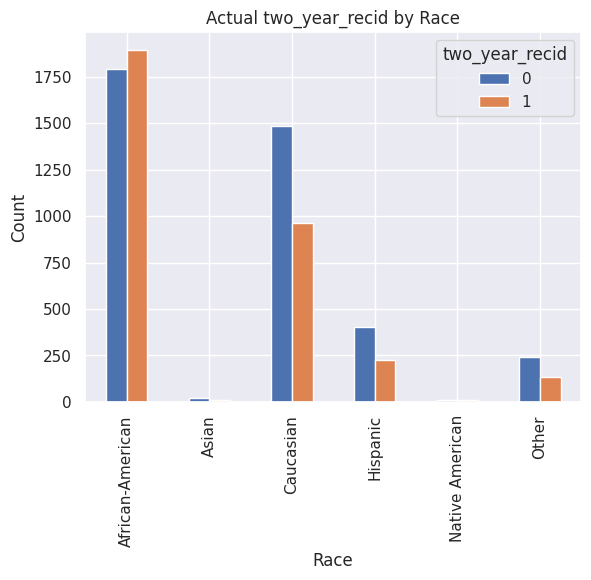

In [ ]:
# Group by race and age_cat, and count occurrences in each group
race_age_cat_count = df.groupby(['race', 'two_year_recid']).size().reset_index(name='count')

# Pivot the DataFrame to make plotting easier
pivot_df = race_age_cat_count.pivot(index='race', columns='two_year_recid', values='count')

# Plotting
pivot_df.plot(kind='bar', stacked=False)
plt.title('Actual two_year_recid by Race')
plt.xlabel('Race')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='two_year_recid')
plt.show()

## Group sample sizes

From the perspective of fairness assessment, a key data characteristic is the sample size of groups with respect to which we conduct fairness assessment.

Small sample sizes have two implications:

* **assessment**: the impacts of the AI system on smaller groups are harder to assess, because due to fewer data points we have a much larger uncertainty (error bars) in our estimates

* **model training**: fewer training data points mean that our model fails to appropriately capture any data patterns specific to smaller groups, which means that its predictive performance on these groups could be worse

Let's examine the sample sizes of the groups according to `race`:



Normalized as frequencies:

In [ ]:
race_distribution = df["race"].value_counts(normalize=True)
race_distribution

,proportion
race,
African-American,0.513
Caucasian,0.341
Hispanic,0.088
Other,0.052
Asian,0.004
Native American,0.002


In our dataset, the defendants are predominantly *African-American* (51%). The next largest racial group is *Caucasian*, making up 34% of the defendants and Hispanic 8%. The remaining race categories (including *Other*) compose about 6% of the data.

We also examine the dataset composition by `gender`:

In [ ]:
df["sex"].value_counts() # counts

,count
sex,
Male,5803
Female,1389


In [ ]:
df["sex"].value_counts(normalize=True) # frequencies

,proportion
sex,
Male,0.807
Female,0.193


Gender is in this study binary (and we have no further information how it was operationalized), with both *Female* represented at 19% and *Male* represented at 80%.

### Decision point: How do we address smaller group sizes?

When the data set lacks coverage of certain groups, it means that we will not be able to reliably assess any fairness-related issues. There are three interventions (which could be carried out in a combination):

* **collect more data**: collect more data for groups with fewer samples
* **buckets**: merge some of the groups
* **drop small groups**

The choice of strategy depends on our existing understanding of which groups are at the greatest risk of a harm. In particular, pooling the groups with widely different risks could mask the extent of harms. We generally caution against dropping small groups as this leads to the representational harm of erasure the model will not be inclusive.

If any groups are merged or dropped, these decisions should be explained.

In our case, we will keep the groups as they are.



Examine the distribution of the `age` feature in the dataset.

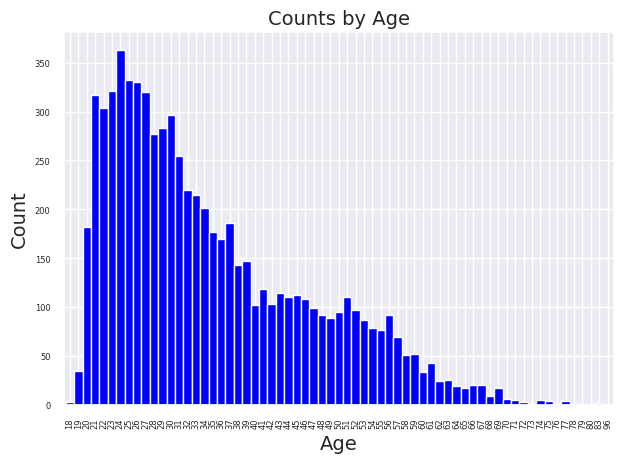

In [ ]:
# df["age"].value_counts().plot(kind='bar', rot=90, width=2, fontsize=6);
# Count occurrences by age
age_count = df['age'].value_counts().sort_index()

# Plotting
ax = age_count.plot(kind='bar', color='blue', width=1, fontsize=6)  # Adjust bar width
plt.title('Counts by Age', fontsize=14)                       # Adjust title font size
plt.xlabel('Age', fontsize=14)                                # Adjust x-label font size
plt.ylabel('Count', fontsize=14)                              # Adjust y-label font size
plt.xticks(rotation=90)

# Adjust space between bars
ax.set_xticks(ax.get_xticks()[::1])  # Adjust ticks frequency
ax.set_xticklabels(age_count.index)  # Adjust tick labels
plt.tight_layout()                   # Adjust layout

plt.show()

Most defendants in our data set belong to the *Under 40 years* category. Although we will not be assessing for age-based fairness-related harms in this tutorial, we want to document the age imbalance in our dataset.

## Examining the choice of label

Next we dive into the question of whether our choice of label (recidivism) aligns with our goal (release defendants that are unlikely to reoffend within 2 years of release).

A framework particularly suited for this analysis is called _measurement modeling_ (see, e.g., [Jacobs and Wallach, 2021](https://arxiv.org/abs/1912.05511)). The goal of measurement modeling is to describe the relationship between what we care about and what we can measure. The thing that we care about is referred to as the _construct_ and what we can observe is referred to as the _measurement_. In our case:
* **construct** = greatest benefit from a fairer risk assessment
* **measurement** = recidivism within 2 years

In our case, the **measurement** coincides with the **classification label**.

The act of _operationalizing_ the construct via a specific measurement corresponds to making certain assumptions. In our case, we are making the following assumption: **the greatest benefit to society from risk assessment would be for false positive high risk defendants** (in the absence of risk assessment) **who are unlikely to reoffend within 2 years get released and false negative high risk defendants get detained.**

### How can we check whether our assumptions apply?

In the terminology of measurement modeling, how do we establish _construct validity_? Following, [Jacobs and Wallach, 2021](https://arxiv.org/abs/1912.05511),

> Establishing construct
validity means demonstrating, in a variety of ways, that the measurements obtained from measurement model are both meaningful
and useful:
> * Does the operationalization capture all relevant aspects
of the construct purported to be measured?
> * Do the measurements
look plausible?
> * Do they correlate with other measurements of the
same construct? Or do they vary in ways that suggest that the
operationalization may be inadvertently capturing aspects of other
constructs?
> * Are the measurements predictive of measurements of
any relevant observable properties (and other unobservable theoretical constructs) thought to be related to the construct, but not incorporated into the operationalization?

We focus on one aspect of construct validity, called _predictive validity_, which refers to the extent
to which the measurements obtained from a measurement model
are predictive of measurements of any relevant observable properties
related to the construct purported to be measured, but not incorporated into the operationalization.

The predictions do not need to be chronological, meaning that we do not necessarily need to be predicting future from the past. Also, the predictions do not need to be causal (going from causes to effects). We just need to ensure that the predicted property is not part of the measurement whose validity we're checking.  


### Predictive validity

We would like to show that our measurement `two_year_recid` is correlated with defendant characteristics that are related to our construct "low risk defendants are released and high risk detained". One such characteristic is the **priors_count,** where we expect that defendants with high prior offences are likely to recid.

While our data does not contain full criminal records that would enable us to holistically measure general criminality, the data does contain two relevant features: `priors_count` and `c_jail_days`, which indicate how many days the defendant spent in jail before release from arrest date.

To establish predictive validity, we would like to show that our measurement `two_year_recid` is predictive of these two characteristics.

First, let's check the rate at which the defendants with different `two_year_recid` labels reoffended:

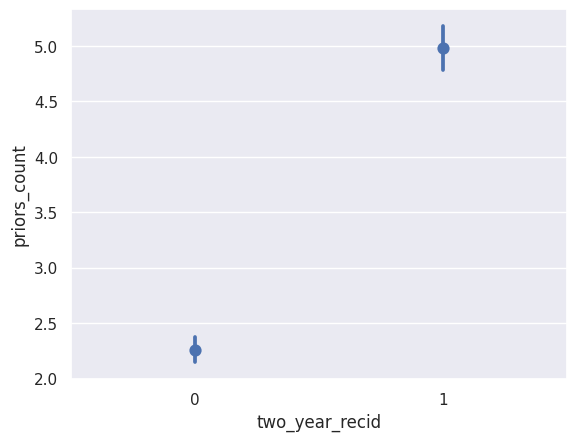

In [ ]:
sns.pointplot(y="priors_count", x="two_year_recid",
              data=df, errorbar=('ci', 95), linestyle='none');

The plot shows that indeed defendants with a low prior_count have a lower rate of recidivism `two_year_recid=0`, whereas defendants with `two_year_recid=1` have a higher prior_count. (The vertical lines indicate 95% confidence intervals obtained via boostrapping.)

 Non-recidivists (two_year_recid = 0):

 The average number of prior offenses is lower for individuals who did not reoffend within two years.
 The confidence interval is narrow, indicating a precise estimate of the mean priors count.

 Recidivists (two_year_recid = 1):
 The average number of prior offenses is higher for individuals who reoffended within two years.
 The confidence interval is also narrow, showing a precise estimate for this group as well.</br>
 **Conclusion**:
 The plot clearly shows that individuals who recidivated within two years had, on average, a higher number of prior offenses compared to those who did not recidivate. The narrow confidence intervals suggest that this difference is statistically significant and not due to random variation. This indicates a positive correlation between the number of prior offenses and the likelihood of recidivism within two years.

We see a similar pattern when `c_jail_days`('c_jail_out' minus 'c_jail_in' = c_jail_days, number of days spent in jail) is used to predict the two_year_recid, the longer the c_jail_days the higher the rate of recidivism whilst defendants who have shorter c_jail_days have a low recidivism.  

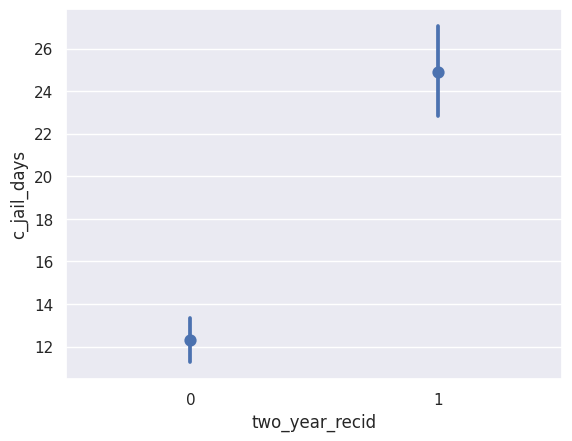

In [ ]:
sns.pointplot(y="c_jail_days", x="two_year_recid",
              data=df, errorbar=('ci', 95), linestyle='none');

The plot shows a similar pattern to the priors_count, the higher the c_jail_days higher the probability to reoffend within two years.

Non-recidivists (two_year_recid = 0):

The average number of jail days is lower for individuals who did not reoffend within two years.
The confidence interval is narrow, indicating a range within which the true mean likely falls.
Recidivists (two_year_recid = 1):

The average number of jail days is higher for individuals who reoffended within two years.
The confidence interval for this group also indicates a narrow range for the mean jail days.
**Conclusion**:
The plot indicates that individuals who recidivated within two years spent, on average, more days in jail compared to those who did not recidivate. This suggests a positive correlation between the number of days spent in jail and the likelihood of recidivism within two years. The presence of confidence intervals helps in understanding the variability and reliability of these estimates.

Now let's take a look whether the predictiveness is similar across different race groups. First, let's check how well `priors_count`  predicts :`two_year_recid` by race group




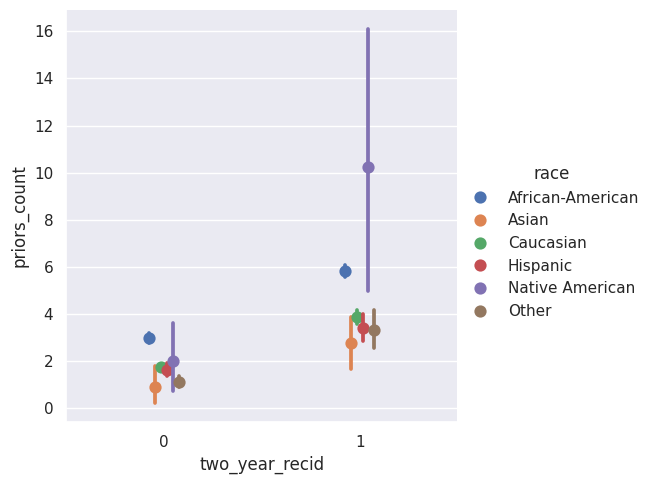

In [ ]:
# Visualize predictiveness using a categorical pointplot
sns.catplot(y="priors_count", x="two_year_recid", hue="race", data=df,
            kind="point", errorbar=('ci', 95), linestyle='none', dodge=True);

Key Observations by Race:
General Trend:

Across all races, individuals who recidivated within two years (two_year_recid = 1) generally have a higher average number of prior offenses compared to those who did not recidivate (two_year_recid = 0).</br>

**Race-Specific Insights**:

African-American:
Non-recidivists: The average priors count is lower compared to recidivists.
Recidivists: They show a higher average priors count. The confidence interval is relatively tight, indicating a reliable estimate.
Caucasian:
Non-recidivists: Similar trend as African-Americans, but with slightly different average priors count.
Recidivists: Higher average priors count, but the increase compared to non-recidivists might differ in magnitude.
Other Races (e.g., Hispanic, Asian):
The pattern generally holds where recidivists have more priors count.
Some racial groups might have larger confidence intervals, indicating more variability or less data for those groups.
Detailed Conclusions:
Higher Priors Count for Recidivists:

The consistent trend across all racial groups that individuals who recidivated had more prior offenses suggests that a higher priors count might be associated with factors contributing to recidivism, such as the severity of offenses or a history of criminal behavior.
Racial Differences:

There are observable differences in the average number of prior offenses across races. For instance, African-Americans and Caucasians show differences in both the average number of prior offenses and the magnitude of difference between recidivists and non-recidivists. This might point to systemic issues such as differences in policing, access to legal resources, or other socio-economic factors.
Precision and Variability:

The confidence intervals provide insight into the precision of the estimates. Tighter confidence intervals for certain racial groups indicate more reliable estimates, while wider intervals suggest greater variability or a smaller sample size for that group.

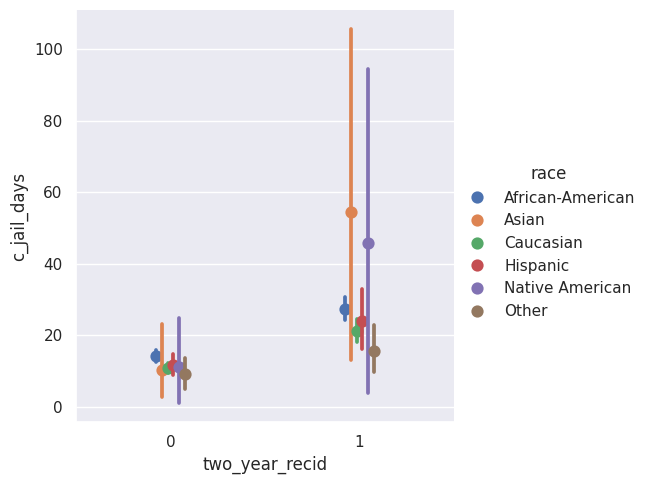

In [ ]:
sns.catplot(y="c_jail_days", x="two_year_recid", hue="race", data=df, kind="point",  errorbar=('ci', 95), linestyle='none', dodge=True);

Jail days by Race:</br>

General Trend:
Across all races, individuals who recidivated within two years (two_year_recid = 1) generally spent more days in jail on average compared to those who did not recidivate (two_year_recid = 0).
Race-Specific Insights:

African-American:
Non-recidivists: The average number of jail days is lower compared to recidivists.<br>
Recidivists: They show a higher average number of jail days. The confidence interval is relatively tight, indicating a reliable estimate.
Caucasian:
Non-recidivists: Similar trend as African-Americans, but with slightly different average jail days.<br>
Recidivists: Higher average jail days, but the increase compared to non-recidivists might differ in magnitude.
Other Races (e.g., Hispanic, Asian):
The pattern generally holds where recidivists spend more days in jail.
Some racial groups might have larger confidence intervals, indicating more variability or less data for those groups.<br>

Detailed Conclusions:<br>

Higher Jail Days for Recidivists:
The consistent trend across all racial groups that individuals who recidivated spent more days in jail suggests that a higher number of jail days might be associated with factors contributing to recidivism, such as the severity of offenses or lack of rehabilitative support.

**Racial Difference**s:<br>
There are observable differences in the average number of jail days across races. For instance, African-Americans and Caucasians show differences in both the average number of jail days and the magnitude of difference between recidivists and non-recidivists. This might point to systemic issues such as differences in sentencing, access to legal resources, or other socio-economic factors.

Precision and Variability:<br>
The confidence intervals provide insight into the precision of the estimates. Tighter confidence intervals for certain racial groups indicate more reliable estimates, while wider intervals suggest greater variability or a smaller sample size for that group.

Check the predictive validity with respect to `gender` and `age` to see if there are any differences?

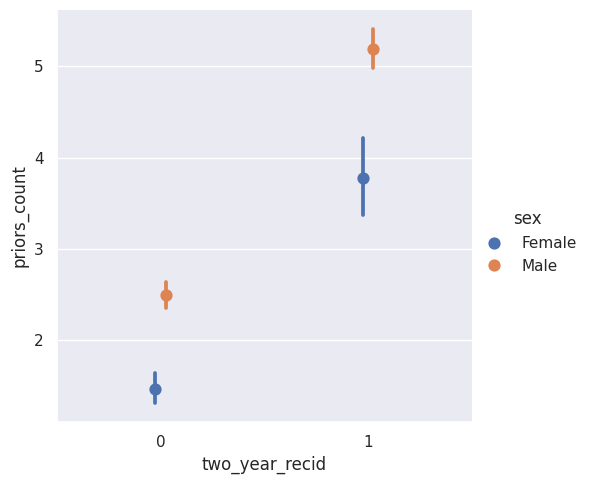

In [ ]:
# Check for predictive validity by gender
sns.catplot(y="priors_count", x="two_year_recid", hue="sex", data=df,
            kind="point", errorbar=('ci', 95), linestyle='none', dodge=True);

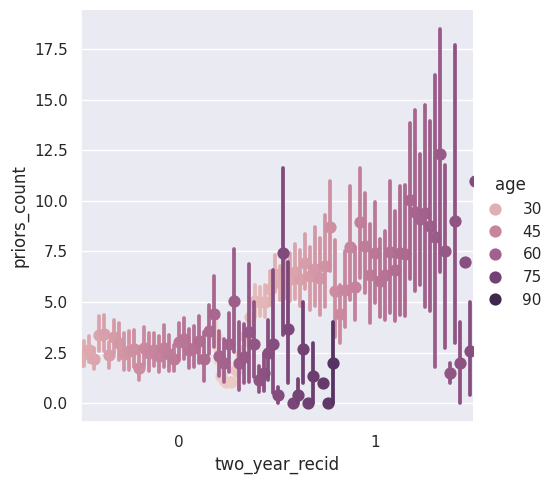

In [ ]:
# Check for predictive validity by age
sns.catplot(y="priors_count", x="two_year_recid", hue="age", data=df,
            kind="point", errorbar=('ci', 95), linestyle='none', dodge=True);

## Label imbalance



Now that we have established the validity of our label, we will check frequency of its values in our data. The frequency of different labels is an important descriptive characteristic in classification settings for several reasons:

* some classification algorithms and performance measures might not work well with data sets with extreme class imbalance
* in binary classification settings, our ability to evaluate error is often driven by the size of the smaller of the two classes (again, the smaller the sample the larger the uncertainty in estimates)
* label imbalance may exacerbate the problems due to smaller group sizes in fairness assessment



Let's check how many samples in our data are labeled as positive and how many as negative.

In [ ]:
df["two_year_recid"].value_counts() # counts

,count
two_year_recid,
0,3956
1,3236


In [ ]:
df["two_year_recid"].value_counts(normalize=True) # frequencies

,proportion
two_year_recid,
0,0.550
1,0.450


0 (No recidivism within two years): 3956 individuals<br>
 1 (Recidivism within two years): 3236 individuals<br>
 This indicates that out of the dataset, 3956 individuals did not reoffend within two years, while 3236 individuals did reoffend within the same period.


*Our target metric is **balanced error rate**, which is the average of FPR and FNR. The value of this metric is robust to different frequencies of positives and negatives. However, since half of the metric is contributed by FNR, we expect the uncertainty in balanced error values to behave similarly to the uncertainty of FNR*

Now, let's examine how much the label frequencies vary within each group defined by `race`:

recidivism by race # label variance by race, ;
 Key Observations:
 African-American:

 The bar for 1 (recidivism) is taller than the bar for 0 (no recidivism), indicating a higher proportion of African-Americans in the dataset recidivated within two years.
 The confidence intervals for both bars are relatively narrow, suggesting a precise estimate of the proportions.
 Caucasian:

 The bars for 0 and 1 are closer in height compared to African-Americans, indicating a smaller difference in the proportion of recidivism versus non-recidivism.
 The confidence intervals are narrow, indicating a reliable estimate.
 Other Races:

 The pattern varies among other racial groups, but generally, there are differences in the proportions of recidivism and non-recidivism.
 Some groups may have wider confidence intervals, indicating more variability or a smaller sample size for those groups.
 Detailed Conclusions:
 Higher Proportion of Recidivism Among African-Americans:

 African-Americans have a higher proportion of individuals who recidivated within two years compared to those who did not. This suggests a higher likelihood of reoffending within this group.
 The precise confidence intervals strengthen the reliability of this observation.
 Comparative Proportions Among Caucasians:

 The proportions of recidivism and non-recidivism among Caucasians are more balanced, with less difference between the two bars. This indicates that Caucasians in the dataset have a more evenly distributed likelihood of reoffending or not.
 Variability Among Other Races:

 The variability in the bar heights and confidence intervals for other racial groups suggests differing patterns of recidivism. This might be due to a variety of socio-economic, cultural, or systemic factors.

 The smaller sample size of the *Other* and *Unknown* groups mean that there is more uncertainty around the estimate for these two groups.

## Proxies for sensitive features



We next investigate which of the features are highly predictive of the sensitive feature *race*; such features are called *proxies*.

We examine fairness issues through the **impact** of the machine-learning model on different populations, there are other concepts of fairness that seek to analyze how the **model might be using information** contained in the sensitive features, and which of the information uses are justified (often using causal reasoning). More pragmatically, certain uses of sensitive features (or proxies of it) might be illegal in some contexts.

Another reason to understand the proxies is because they might explain why we see differences in impact on different groups even when our model does not have access to the sensitive features directly.

In this section we briefly examine the identification of such proxies (but we don't go into legal or causality considerations).


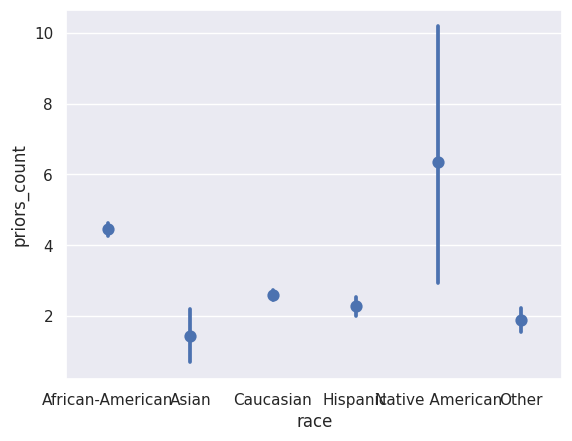

In [ ]:
sns.pointplot(y="priors_count", x="race", data=df, errorbar=('ci', 95), linestyle='none');

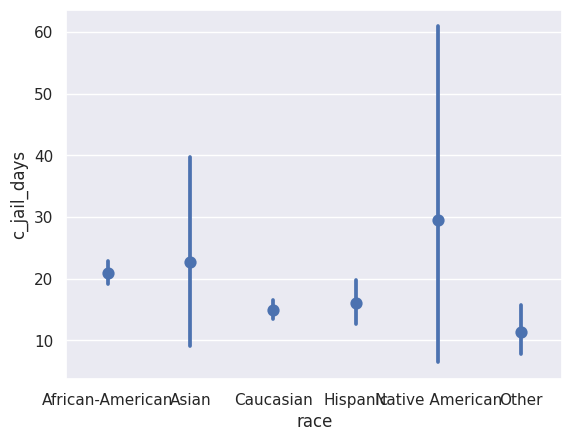

In [ ]:
sns.pointplot(y="c_jail_days", x="race", data=df, errorbar=('ci', 95), linestyle='none');

## Additional validity checks

Similarly as we used predictive validity to check that our label aligns with the construct of "likely to recidivate", we can use predictive validity to verify that our various features are coherent with each other.


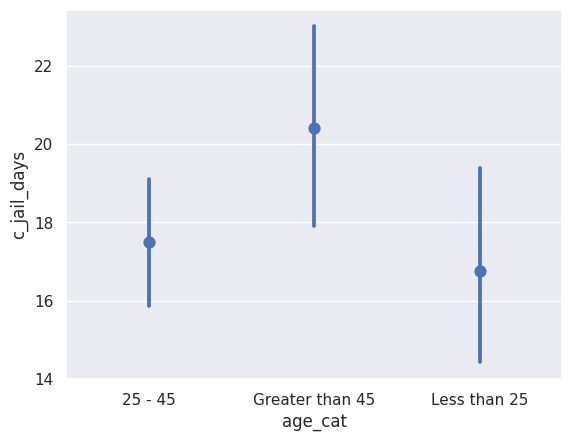

In [ ]:
sns.pointplot(y="c_jail_days", x="age_cat", data=df, errorbar=('ci', 95), linestyle='none');

As we see, that's indeed the case.

# Training the initial model

We next train a classification model to predict our target variable (two_year_recid) while optimizing balanced accuracy.

What kind of model should we train?

There are a variety of considerations. We highlight two:

* **Interpretability.** Interpretability is tightly linked with questions of fairness. There are several reasons why it is important to have interpretable models that are open to the stakeholder scrutiny:
  * It allows discovery of fairness issues that migt not have been discovered by the data science team.
  * It provides a path toward recourse for those that are affected by the model.
  * It allows for a *face validity* check, a "sniff test", by experts to verify that the model "makes sense" (at the face value). While this step is subjective, it is really important when the model is applied to different populations than those on which the assessment was conducted.

* **Model expressiveness.** How well can the model separate positive examples from negative examples? How well can it do so given the available dataset size? Can it do so across all groups or does it need to trade off performance on one group against performance on another group?

Some additional considerations are training time (this impacts the ability to iterate), familiarity (this impacts the ability to fine tune and debug), and carbon footprint (this impacts the Earth climate both directly and indirectly by normalizing unnecessarily heavy workloads).

### Decision point: Model type

We will use a logistic regression model. Our reasoning:

* **Interpretability**. Logistic models over a small number of variables (as used here) are highly interpretable in the sense that stakeholders can simulate them easily.

* **Model expressiveness**. Logistic regression predictions are described by a linear weighting of the feature values. The concern might be that this is too simple, we use a second model, Naive Bayes to compare so we have a higher confidence in the result.

## Prepare training and test datasets

As we mentioned in the task definition, our target variable is **two_year_recid**, and our sensitive feature for the purposes of fairness assessment is **race**.


In [ ]:
target_variable = "two_year_recid"
demographic = ["race", "gender"]
sensitive = ["race"]
# If multiple sensitive features are chosen, the rest of the script considers intersectional groups.

In [ ]:
# Drop the target variable to create a feature set X
X = df.drop(columns=['two_year_recid'])

In [ ]:
print(X.columns)

Index(['sex', 'age', 'age_cat', 'race', 'juv_fel_count', 'g_decile_score',
       'juv_misd_count', 'juv_other_count', 'c_jail_days',
       'c_days_from_compas', 'c_charge_degree', 'is_recid', 'is_violent_recid',
       'decile_score', 'score_text', 'v_decile_score', 'v_score_text',
       'priors_count', 'start', 'end', 'event'],
      dtype='object')


In [ ]:
# extract target variable Y and sensitive attributes A
Y, A = df.loc[:, target_variable], df.loc[:, sensitive]

We next drop the features that we don't want to use in our model and expand the categorical features into 0/1 indicators ("dummies").

In [ ]:
X.head() # sanity check

,sex,age,age_cat,race,juv_fel_count,g_decile_score,juv_misd_count,juv_other_count,c_jail_days,c_days_from_compas,...,is_recid,is_violent_recid,decile_score,score_text,v_decile_score,v_score_text,priors_count,start,end,event
0,Male,69,Greater than 45,Other,0,1,0,0,1,1,...,0,0,1,Low,1,Low,0,0,327,0
1,Male,34,25 - 45,African-American,0,3,0,0,10,1,...,1,1,3,Low,1,Low,0,9,159,1
2,Male,24,Less than 25,African-American,0,4,0,1,1,1,...,1,0,4,Low,3,Low,4,0,63,0
3,Male,23,Less than 25,African-American,0,8,1,0,0,1,...,0,0,8,High,6,Medium,1,0,1174,0
4,Male,43,25 - 45,Other,0,1,0,0,0,76,...,0,0,1,Low,1,Low,2,0,1102,0


In [ ]:
X.shape

(7192, 21)

We split our data into a training and test portion. The test portion will be used to evaluate our performance metric (i.e., balanced accuracy), but also for fairness assessment. The split is half/half for training and test to ensure that we have sufficient sample sizes for fairness assessment.

In [ ]:
print(df.shape)
print(df.columns)

(7192, 22)
Index(['sex', 'age', 'age_cat', 'race', 'juv_fel_count', 'g_decile_score',
       'juv_misd_count', 'juv_other_count', 'c_jail_days',
       'c_days_from_compas', 'c_charge_degree', 'is_recid', 'is_violent_recid',
       'decile_score', 'score_text', 'v_decile_score', 'v_score_text',
       'priors_count', 'start', 'end', 'event', 'two_year_recid'],
      dtype='object')


In [ ]:
# random seed to ensure reproducibility
random_seed = 445
np.random.seed(random_seed)

In [ ]:
X_train, X_test, Y_train, Y_test, A_train, A_test, df_train, df_test = train_test_split(
    X,
    Y,
    A,
    df,
    test_size=0.50,
    stratify=Y,
    random_state=random_seed
)

(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape, A_train.shape, A_test.shape, df_train.shape, df_test.shape)

((3596, 21),
 (3596, 21),
 (3596,),
 (3596,),
 (3596, 1),
 (3596, 1),
 (3596, 22),
 (3596, 22))

Our performance metric is **balanced accuracy**, so for the purposes of training (but not evaluation!) we will resample the data set, so that it has the same number of positive and negative examples. This means that we can use estimators that optimize standard accuracy (although some estimators allow the use us importance weights).


Because we are downsampling the number of negative examples, we create a training dataset with a significantly lower number of data points. For more complex machine learning models, this lower number of training data points may affect the model's accuracy.

In [ ]:
# ????? why Because we are downsampling the number of negative examples

In [ ]:
def resample_dataset(X_train, Y_train, A_train):

  negative_ids = Y_train[Y_train == 0].index
  positive_ids = Y_train[Y_train == 1].index
  balanced_ids = positive_ids.union(np.random.choice(a=negative_ids, size=len(positive_ids)))

  X_train = X_train.loc[balanced_ids, :]
  Y_train = Y_train.loc[balanced_ids]
  A_train = A_train.loc[balanced_ids, :]
  return X_train, Y_train, A_train



In [ ]:
X_train_bal, Y_train_bal, A_train_bal = resample_dataset(X_train, Y_train, A_train)

(X_train_bal.shape, Y_train_bal.shape, A_train_bal.shape)

((3236, 21), (3236,), (3236, 1))

The training set has been successfully resampled and balanced as shown in the above shapes.

## Save descriptive statistics of training and test data

We next evaluate and save descriptive statistics of the training dataset. These will be provided as part of _model cards_ to document our training.

In [ ]:
# save the figure to a string in base64 format
import io
import base64

def figure_to_base64str(fig):
  buf = io.BytesIO()
  fig.savefig(buf, format='png')
  buf.seek(0)
  img_base64 = base64.b64encode(buf.read()).decode('utf-8')
  return img_base64

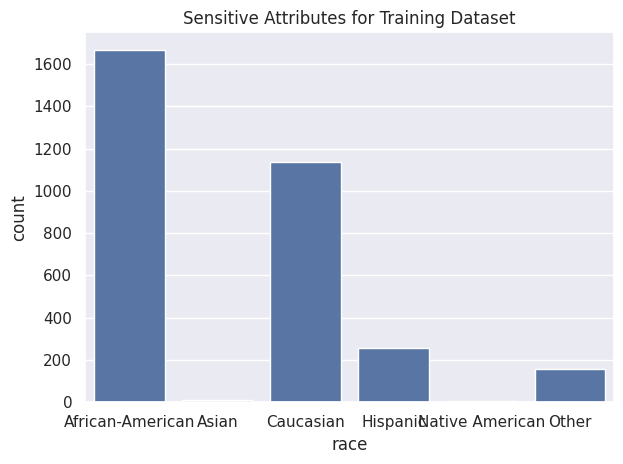

In [ ]:
sns.countplot(x="race", data=A_train_bal)
plt.title("Sensitive Attributes for Training Dataset")
sensitive_train = figure_to_base64str(plt)
plt.tight_layout()

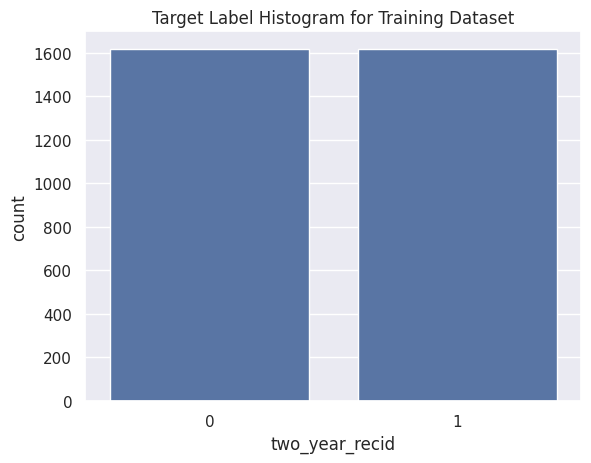

In [ ]:
sns.countplot(x=Y_train_bal)
plt.title("Target Label Histogram for Training Dataset")
outcome_train = figure_to_base64str(plt)

The histogram shows a balanced training set, same number of positives and negatives.

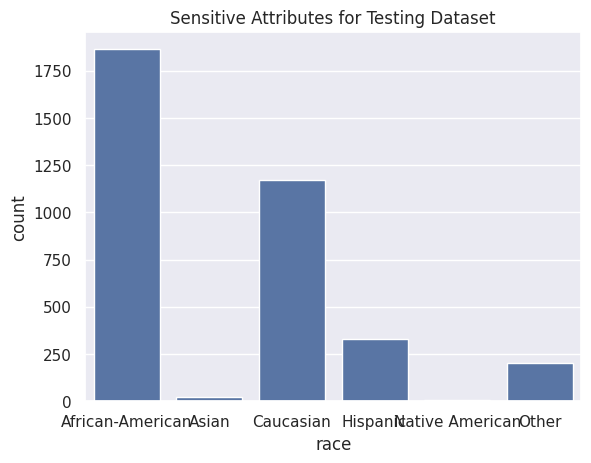

In [ ]:
sns.countplot(x="race", data=A_test)
plt.title("Sensitive Attributes for Testing Dataset")
sensitive_test = figure_to_base64str(plt)

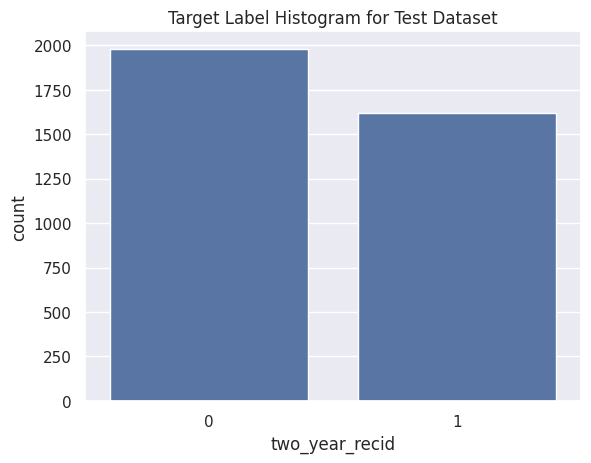

In [ ]:
sns.countplot(x=Y_test)
plt.title("Target Label Histogram for Test Dataset")
outcome_test = figure_to_base64str(plt)

## Train the model : Logistic regression

We train a logistic regression model and save its predictions on test data for analysis.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

 # Identify categorical columns
categorical_cols = X.select_dtypes(include=['category']).columns

 # Define the preprocessing for numerical and categorical features
preprocessor = ColumnTransformer(
     transformers=[
         ('num', StandardScaler(), X.select_dtypes(exclude=['category']).columns),
         ('cat', OneHotEncoder(), categorical_cols)
     ])

 # Define the pipeline with preprocessing and logistic regression
unmitigated_pipeline = Pipeline(steps=[
     ("preprocessing", preprocessor),
     ("logistic_regression", LogisticRegression(max_iter=1000))
 ])

 # Fit the pipeline
unmitigated_pipeline.fit(X_train, Y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['age', 'juv_fel_count', 'g_decile_score', 'juv_misd_count',
       'juv_other_count', 'c_jail_days', 'c_days_from_compas', 'is_recid',
       'is_violent_recid', 'decile_score', 'v_decile_score', 'priors_count',
       'start', 'end', 'event'],
      dtype='object')),
                                                 ('cat', OneHotEncoder(),
                                                  Index(['sex', 'age_cat', 'race', 'c_charge_degree', 'score_text',
       'v_score_text'],
      dtype='object'))])),
                ('logistic_regression', LogisticRegression(max_iter=1000))])

The pipeline which includes preprocessing, and logistic regression has been successfully fitted to the training data.

In [ ]:
# Predict the probabilities and labels for the test set
Y_pred_proba = unmitigated_pipeline.predict_proba(X_test)[:,1]
Y_pred = unmitigated_pipeline.predict(X_test)

# display the first 5 probabilities and predictions
Y_pred_proba[:5], Y_pred[:5]

(array([2.25774432e-06, 9.95931125e-01, 9.97807681e-01, 3.51779293e-01,
        9.40490624e-07]),
 array([0, 1, 1, 0, 0]))

Check model performance on test data.

Text(0, 0.5, 'True Positive Rate')

<Figure size 1000x600 with 0 Axes>

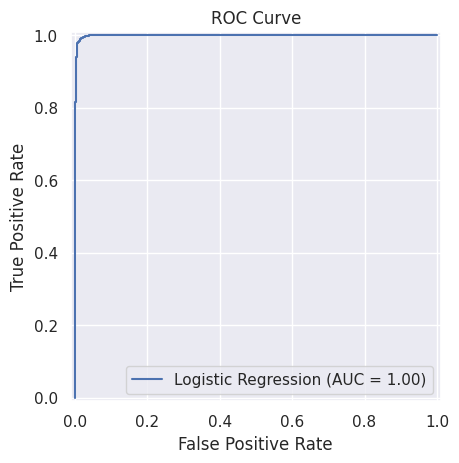

In [ ]:
# Plot ROC curve of probabilistic predictions

import sklearn.metrics as metrics

# Compute ROC curve and ROC area for the test set predictions

fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred_proba)
roc_auc = metrics.auc(fpr, tpr)

# plot ROC curve
plt.figure(figsize=(10,6))
metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Logistic Regression').plot()
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

The FPR represents number the of actual negatives incorrectly identified as positives by the model. the diagonal line from (0,0) to (1,1) represents  a perfect classifier.
Any point above this line indicates a better than random classifier wjile points below indicate a worse than random perfomance. In this case the Area under the curve follows the left hand border and then the top border of the ROC space, the higher the AUC the better the model is at distinguishing between positive and negative classes.
The ROC curve is well above the the diagonal line indicating that the model performs better than random guessing.

In [ ]:
# Show balanced accuracy rate of the 0/1 predictions
balanced_accuracy_score(Y_test, Y_pred)

0.9865735700867766

As we see, the performance of the model is well above the performance of a coin flip (whose performance would be 0.5 in both cases), albeit it is quite far from a perfect classifier (whose performance would be 1.0 in both cases).

The balanced accuracy score is the average of the recall obtained on each class. It is particularly useful when dealing with imbalanced datasets, as it considers the performance on both the majority and minority classes.</br>

*Score Value*:
The balanced accuracy score for the logistic regression model on the test set is approximately 0.987. This value ranges from 0 to 1, with 1 being perfect accuracy.
Key Observations:
High Balanced Accuracy:
A score of 0.987 indicates that the model performs exceptionally well in correctly classifying both the recidivists and non-recidivists.
This high score suggests that the model is not biased towards either class and handles the class imbalance effectively.
Conclusions:
Model Effectiveness:
The high balanced accuracy score demonstrates that the logistic regression model is highly effective in predicting recidivism within two years.
This performance metric confirms that the model is reliable and can be trusted for making predictions on similar datasets


In [ ]:
cm = confusion_matrix(Y_test, Y_pred)
print(cm)

[[1942   36]
 [  14 1604]]


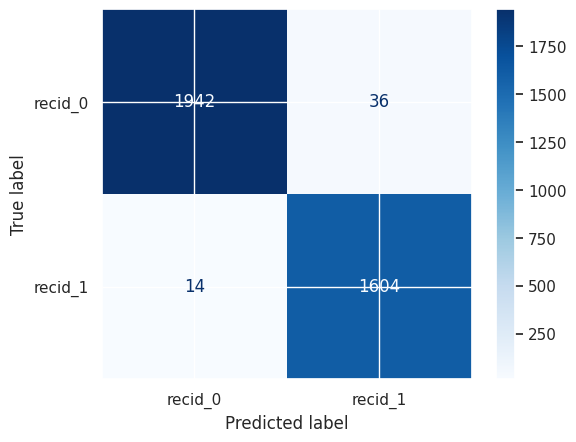

In [ ]:
# Display the confusion matrix
target_names = ['recid_0', 'recid_1']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

**Interpretation of the Confusion Matrix**:</br>
 True Negatives (TN): 1942
 The model correctly predicted 1942 non-recidivists.
 False Positives (FP): 36
 The model incorrectly predicted 36 non-recidivists as recidivists.
 False Negatives (FN): 14
 The model incorrectly predicted 14 recidivists as non-recidivists.
 True Positives (TP): 1604
 The model correctly predicted 1604 recidivists.
 The model has a high number of true positives and true negatives, indicating strong performance in both identifying recidivists and non-recidivists.
 The number of false positives and false negatives is relatively low, which further supports the high balanced accuracy score observed earlier.

## Inspect the coefficients of trained model

We check the coefficients of the fitted model to make sure that they "make sense". While subjective, this step is important and helps catch mistakes and might point out to some fairness issues. However, we will systematically assess the fairness of the model in the next section.

*Note that coefficients are also a proxy for "feature importance", but this interpretation can be misleading when features are highly correlated.*

In [ ]:
print(len(unmitigated_pipeline.named_steps["logistic_regression"].coef_[0]))

34


In [ ]:
X_transformed = unmitigated_pipeline.named_steps["preprocessing"].transform(X)
# Get the featurenames frm the preprocessing step
feature_names = unmitigated_pipeline.named_steps["preprocessing"].get_feature_names_out()


<Axes: >

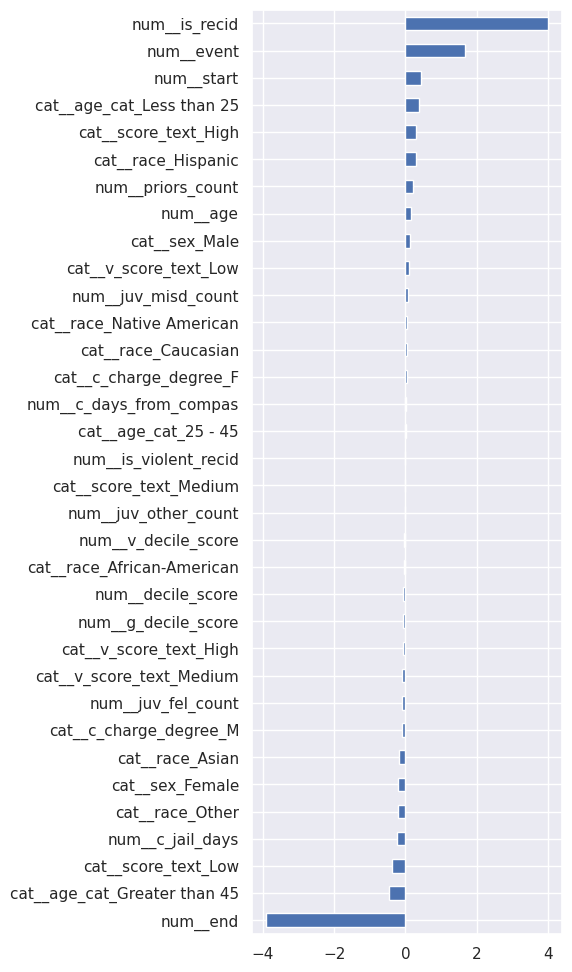

In [ ]:
# Create the Series with aligned values and index
coef_series = pd.Series(data=unmitigated_pipeline.named_steps["logistic_regression"].coef_[0], index=feature_names)

# Plot the coefficients
coef_series.sort_values().plot.barh(figsize=(4, 12), legend=False)

# **Fairness assessment**: Logistic model

## Measuring fairness-related harms





The goal of fairness assessment is to answer the question: *Which groups of people may be disproportionately negatively impacted by an AI system and in what ways?*

The steps of the assesment are as follows:
1. Identify harms
2. Identify the groups that might be harmed
3. Quantify harms
4. Compare quantified harms across the groups

We next examine these four steps in more detail.

### 1. Identify harms

For example, in a system for screening job applications, qualified candidates that are automatically rejected experience an allocation harm. In a speech-to-text transcription system, high error rates constitute harm in the quality of service.

**In the criminal justice scenario**, the defendants that would benefit from a fair recidivism score, but are scored as high risk therefore getting longer sentences, experience a quality of service harm. In the context of the classification scenario these are **FALSE POSITIVES**.

### 2. Identify the groups that might be harmed

In most applications, we consider demographic groups including historically marginalized groups (e.g., based on gender, race, ethnicity). We should also consider groups that are relevant to a particular application. For example, for speech-to-text transcription, groups based on the regional dialect or being a native or a non-native speaker.

It is also important to consider group intersections, for example, in addition to considering groups according to gender and groups according to race, it is also important to consider their intersections (e.g., Black women, Latinx nonbinary people, etc.).

**In the criminal justice scenario**, based on the previous work, we focus on groups defined by Race.

### 3. Quantify harms

Define metrics that quantify harms or benefits:

* **In the criminal justice scenario**, we could consider two metrics for quantifying harms / benefits:
  * **positive rate**: fraction of defendants that do not recidivate  within 2 years (low risk), but that were scored as likely to recid; this quantifies harm
  * **selection rate**: overall fraction of defendants that are scored as low risk of recidivism (regardless of whether they recid or not); this quantifies benefit; here the assumption is that all defendants benefit similarly from the scoring.

There are several reasons for including selection rate in addition to false positive rate. We would like to monitor how the benefits are allocated, focusing on groups that might be disadvantaged. Another reason is to get extra robustness in our assessement, because our measure (i.e., recidivism within 2 years) is only an imperfect measure of our construct (greatest benefit from a fairer risk assessment). The auxiliary metrics, like selection rate, may alert us to large disparities in how the benefit is allocated, and allow us to catch issues that we might have missed.


### 4. Compare quantified harms across the groups

The workhorse of fairness assessment are _disaggregated metrics_, which are **metrics evaluated on slices of data**. For example, to measure harms due to errors, we would begin by evaluating the errors on each slice of the data that corresponds to a group we identified in Step 2.
If some of the groups are seeing much larger errors than other groups, we would flag this as a fairness harm.

To summarize the disparities in errors (or other metrics), we may want to report quantities such as the **difference** or **ratio** of the metric values between the best and the worst slice. In settings where the goal is to guarantee certain minimum quality of service (such as speech recognition), it is also meaningful to report the **worst performance** across all considered groups.



For example, when comparing false positive rate across groups defined by race, we may summarize our findings with a table like the following:

| | false positive rate<br>(FPR) |
|---|---|
| AfricanAmerican | 0.43 |
| Caucasian | 0.44 |
| Other | 0.52 |
| Unknown | 0.67 |
| | |
|_largest difference_| 0.24 &nbsp;&nbsp;(best is 0.0)|
|_smallest ratio_| 0.64 &nbsp;&nbsp;(best is 1.0)|
|_maximum_<br>_(worst-case) FPR_|0.67|

## Fairness assessment with Fairlearn `MetricFrame` and Aequitas toolkits

## Logistic regresssion : Fairness metrics using Fairlearn library</br>
Fairlearn provides the data structure called `MetricFrame` to enable evaluation of disaggregated metrics. We will show how to use a `MetricFrame` object to assess the trained `LogisticRegression` classifier for potential fairness-related harms.



In [ ]:
# In its simplest form MetricFrame takes four arguments:
#    metric_function with signature metric_function(y_true, y_pred)
#    y_true: array of labels
#    y_pred: array of predictions
#    sensitive_features: array of sensitive feature values

mf1 = MetricFrame(metrics=false_positive_rate,
                  y_true=Y_test,
                  y_pred=Y_pred,
                  sensitive_features=df_test['race'])

# The disaggregated metrics are stored in a pandas Series mf1.by_group:

mf1.by_group

/usr/local/lib/python3.10/dist-packages/fairlearn/metrics/_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)
/usr/local/lib/python3.10/dist-packages/fairlearn/metrics/_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)
/usr/local/lib/python3.10/dist-packages/fairlearn/metrics/_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)


,false_positive_rate
race,
African-American,0.024
Asian,0.000
Caucasian,0.016
Hispanic,0.010
Native American,0.000
Other,0.008


In [ ]:
# The largest difference, smallest ratio and worst-case performance are accessed as
#   mf1.difference(), mf1.ratio(), mf1.group_max()

print(f"difference: {mf1.difference():.3}\n"
      f"ratio: {mf1.ratio():.3}\n"
      f"max across groups: {mf1.group_max():.3}")

difference: 0.0237
ratio: 0.0
max across groups: 0.0237


In [ ]:
# You can also evaluate multiple metrics by providing a dictionary

metrics_dict = {
    "selection_rate": selection_rate,
    "false_positive_rate": false_positive_rate,
    "balanced_accuracy": balanced_accuracy_score,
    "recall_score": recall_score
}

metricframe_unmitigated = MetricFrame(metrics=metrics_dict,
                  y_true=Y_test,
                  y_pred=Y_pred,
                  sensitive_features=df_test['race'])

# retrive the disaggregated metrics by group
selection_rate_by_group = metricframe_unmitigated.by_group['selection_rate']
fpr_by_group = metricframe_unmitigated.by_group['false_positive_rate']
balanced_accuracy_by_group = metricframe_unmitigated.by_group['balanced_accuracy']
recall_by_group = metricframe_unmitigated.by_group['recall_score']

# print the disaggregated metrics
print("selection_rate")
print(selection_rate_by_group)
print("false_positive_rate")
print(fpr_by_group)
print("balanced_accuracy")
print(balanced_accuracy_by_group)
print("recall_score")
print(recall_by_group)

# differences
selection_rate_difference = selection_rate_by_group.max() - selection_rate_by_group.min() # compute and print the differences
fpr_difference = fpr_by_group.max() - fpr_by_group.min()

print("\n difference in selection rate by group")
print(selection_rate_difference)
print("\n difference in false positive rate by group")
print(fpr_difference)

selection_rate
race
African-American   0.509
Asian              0.261
Caucasian          0.411
Hispanic           0.393
Native American    0.500
Other              0.353
Name: selection_rate, dtype: float64
false_positive_rate
race
African-American   0.024
Asian              0.000
Caucasian          0.016
Hispanic           0.010
Native American    0.000
Other              0.008
Name: false_positive_rate, dtype: float64
balanced_accuracy
race
African-American   0.984
Asian              1.000
Caucasian          0.988
Hispanic           0.995
Native American    1.000
Other              0.982
Name: balanced_accuracy, dtype: float64
recall_score
race
African-American   0.991
Asian              1.000
Caucasian          0.992
Hispanic           1.000
Native American    1.000
Other              0.972
Name: recall_score, dtype: float64

 difference in selection rate by group
0.247987117552335

 difference in false positive rate by group
0.023681377825618945


/usr/local/lib/python3.10/dist-packages/fairlearn/metrics/_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)
/usr/local/lib/python3.10/dist-packages/fairlearn/metrics/_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)
/usr/local/lib/python3.10/dist-packages/fairlearn/metrics/_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)


In [ ]:
# The largest difference, smallest ratio, and the maximum and minimum values
# across the groups are then all pandas Series, for example:

metricframe_unmitigated.difference()

,0
selection_rate,0.248
false_positive_rate,0.024
balanced_accuracy,0.018
recall_score,0.028


## Logistic regresssion : Fairness metrics using Aequitas library</br>

Aequitas uses specific metric names, and we need to check that we are using the correct ones. Aequitas typically uses pprev for selection rate and tpr for recall. There is no direct metric named bal_acc, so we may need to calculate it separately.

In [ ]:
# Ensure the 'race' column is of type string
aequitas_df = pd.DataFrame({
    'score': Y_pred,
    'label_value': Y_test,
    'race': df_test['race'].astype(str)  # Convert to string if not already
})

# Create Group object
g = Group()

# Get group metrics
xtab, _ = g.get_crosstabs(aequitas_df)

# Compute Bias
b = Bias()
bdf = b.get_disparity_predefined_groups(xtab,
                                        original_df=aequitas_df,
                                        ref_groups_dict={'race': 'Caucasian'},
                                        alpha=0.05,
                                        mask_significance=True)

# Display metrics and bias
print(xtab[['attribute_name', 'attribute_value', 'fpr', 'pprev', 'tpr']]) # Predicted Positive Ratio (pprev)= selection rate, tpr = recall
print(bdf[['attribute_name', 'attribute_value', 'fpr_disparity', 'pprev_disparity', 'tpr_disparity']])



absolute_metrics = g.list_absolute_metrics(xtab)
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

  attribute_name   attribute_value   fpr  pprev   tpr
0           race  African-American 0.024  0.509 0.991
1           race             Asian 0.000  0.261 1.000
2           race         Caucasian 0.016  0.411 0.992
3           race          Hispanic 0.010  0.393 1.000
4           race   Native American 0.000  0.500 1.000
5           race             Other 0.008  0.353 0.972
  attribute_name   attribute_value  fpr_disparity  pprev_disparity  \
0           race  African-American          1.503            1.238   
1           race             Asian          0.000            0.635   
2           race         Caucasian          1.000            1.000   
3           race          Hispanic          0.631            0.957   
4           race   Native American          0.000            1.217   
5           race             Other          0.492            0.860   

   tpr_disparity  
0          1.000  
1          1.008  
2          1.000  
3          1.008  
4          1.008  
5          0.980 

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,0,binary 0/1,1640,race,African-American,948,915,22,8,907,926,934,929,1863,3596
1,0,binary 0/1,1640,race,Asian,6,17,0,0,17,6,6,17,23,3596
2,0,binary 0/1,1640,race,Caucasian,482,691,11,4,687,471,475,698,1173,3596
3,0,binary 0/1,1640,race,Hispanic,129,199,2,0,199,127,127,201,328,3596
4,0,binary 0/1,1640,race,Native American,4,4,0,0,4,4,4,4,8,3596
5,0,binary 0/1,1640,race,Other,71,130,1,2,128,70,72,129,201,3596


In [ ]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,race,African-American,0.980,0.990,0.980,0.010,0.020,0.020,0.010,0.990,0.980,0.580,0.510,0.500
1,race,Asian,1.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.260,0.260
2,race,Caucasian,0.990,0.990,0.980,0.010,0.020,0.020,0.010,0.990,0.980,0.290,0.410,0.400
3,race,Hispanic,0.990,1.000,0.990,0.000,0.020,0.010,0.000,1.000,0.980,0.080,0.390,0.390
4,race,Native American,1.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.500,0.500
5,race,Other,0.990,0.970,0.990,0.020,0.010,0.010,0.030,0.980,0.990,0.040,0.350,0.360


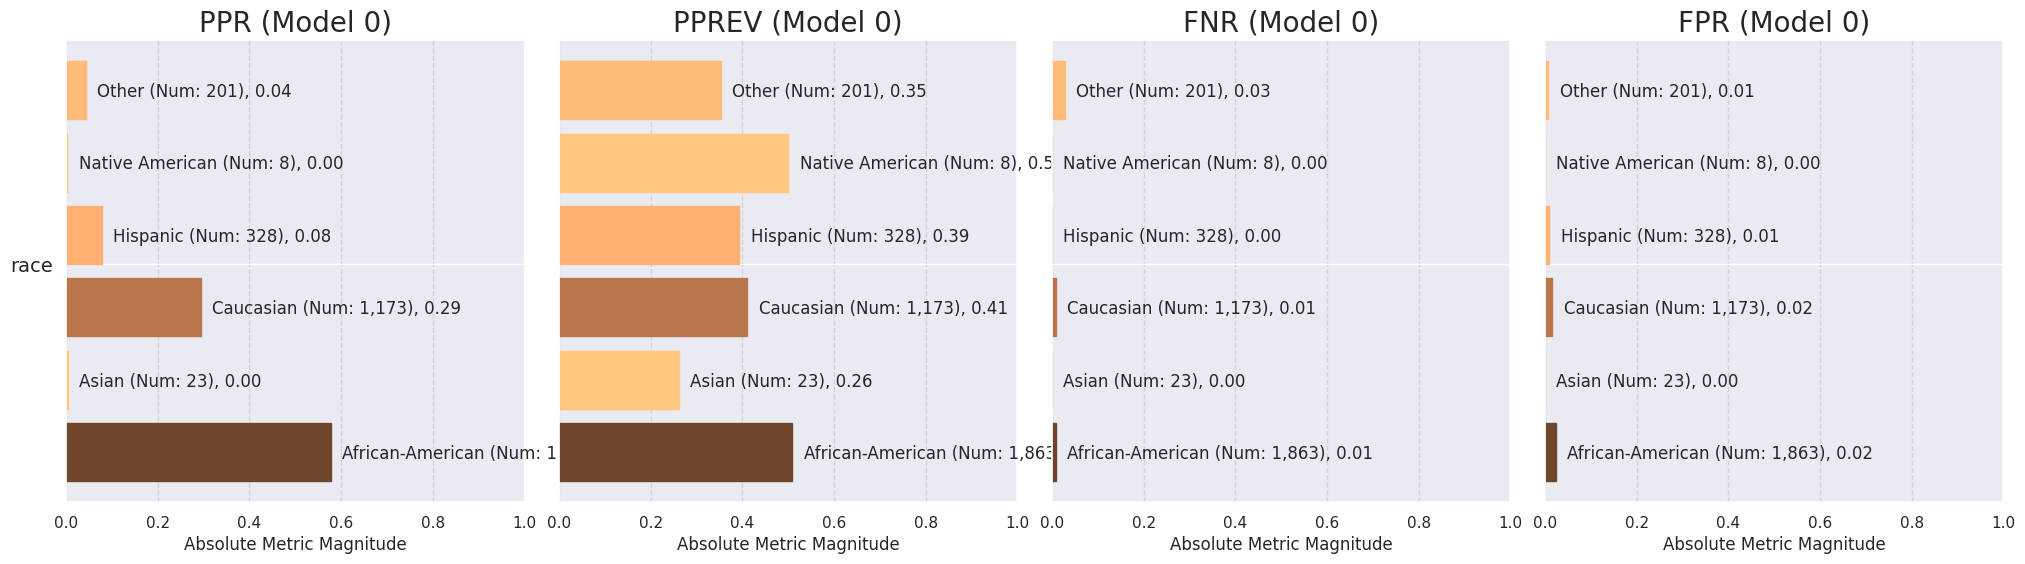

<Figure size 640x480 with 0 Axes>

In [ ]:
aqp = Plot()

# fpr = aqp.plot_group_metric(xtab, 'fpr')
# fpr = aqp.plot_group_metric(xtab, 'fpr', min_group_size=0.05) only plot groups that are bigger than 5%
p = aqp.plot_group_metric_all(xtab, metrics=['ppr','pprev','fnr','fpr'], ncols=4)

We can see that the largest ‘race’ group, African Americans, are predicted positive more often than any other race group (predicted positive rate PPR of 0.66), and are more likely to be incorrectly classified as ‘high’ risk (false positive rate FPR of 0.45) than incorrectly classified as ‘low’ or ‘medium’ risk (false negative rate FNR of 0.28). Note that Native Americans are predicted positive at a higher prevalence PPREVin relation to their group size than all other ‘race groups’ (predicted prevalence of 0.67).

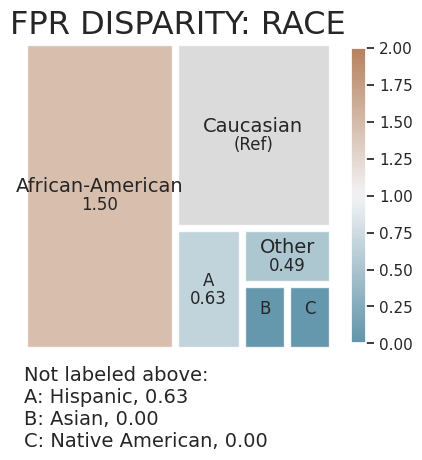

In [ ]:
# bias across groups
b = Bias()
aqp.plot_disparity(bdf, group_metric='fpr_disparity', attribute_name='race', significance_alpha=0.05)

In [ ]:

min_metric_bdf = b.get_disparity_min_metric(df=xtab, original_df=df)
min_metric_bdf.style

,model_id,score_threshold,k,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,ppr_disparity,ppr_ref_group_value,pprev_disparity,pprev_ref_group_value,precision_disparity,precision_ref_group_value,fdr_disparity,fdr_ref_group_value,for_disparity,for_ref_group_value,fpr_disparity,fpr_ref_group_value,fnr_disparity,fnr_ref_group_value,tpr_disparity,tpr_ref_group_value,tnr_disparity,tnr_ref_group_value,npv_disparity,npv_ref_group_value
0,0,binary 0/1,1640,race,African-American,0.983897,0.991435,0.976319,0.008743,0.023207,0.023681,0.008565,0.991257,0.976793,948,915,0.578049,0.508857,22,8,907,926,934,929,1863,3596,0.501342,237.000000,Native American,1.950617,Asian,1.000000,African-American,10.000000,Asian,10.000000,Asian,10.000000,Asian,10.000000,Asian,1.019761,Other,1.000000,African-American,1.006745,Other
1,0,binary 0/1,1640,race,Asian,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,6,17,0.003659,0.260870,0,0,17,6,6,17,23,3596,0.260870,1.500000,Native American,1.000000,Asian,1.023758,African-American,nan,Asian,nan,Asian,nan,Asian,nan,Asian,1.028571,Other,1.024256,African-American,1.015625,Other
2,0,binary 0/1,1640,race,Caucasian,0.987212,0.991579,0.984241,0.005789,0.022822,0.015759,0.008421,0.994211,0.977178,482,691,0.293902,0.410912,11,4,687,471,475,698,1173,3596,0.404945,120.500000,Native American,1.575163,Asian,1.000394,African-American,10.000000,Asian,10.000000,Asian,10.000000,Asian,10.000000,Asian,1.019910,Other,1.008114,African-American,1.009746,Other
3,0,binary 0/1,1640,race,Hispanic,0.993902,1.000000,0.990050,0.000000,0.015504,0.009950,0.000000,1.000000,0.984496,129,199,0.078659,0.393293,2,0,199,127,127,201,328,3596,0.387195,32.250000,Native American,1.507622,Asian,1.007886,African-American,10.000000,Asian,nan,Asian,10.000000,Asian,nan,Asian,1.028571,Other,1.014064,African-American,1.015625,Other
4,0,binary 0/1,1640,race,Native American,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,4,4,0.002439,0.500000,0,0,4,4,4,4,8,3596,0.500000,1.000000,Native American,1.916667,Asian,1.023758,African-American,nan,Asian,nan,Asian,nan,Asian,nan,Asian,1.028571,Other,1.024256,African-American,1.015625,Other
5,0,binary 0/1,1640,race,Other,0.985075,0.972222,0.992248,0.015385,0.014085,0.007752,0.027778,0.984615,0.985915,71,130,0.043293,0.353234,1,2,128,70,72,129,201,3596,0.358209,17.750000,Native American,1.354063,Asian,1.009339,African-American,10.000000,Asian,10.000000,Asian,10.000000,Asian,10.000000,Asian,1.000000,Other,1.016316,African-American,1.000000,Other


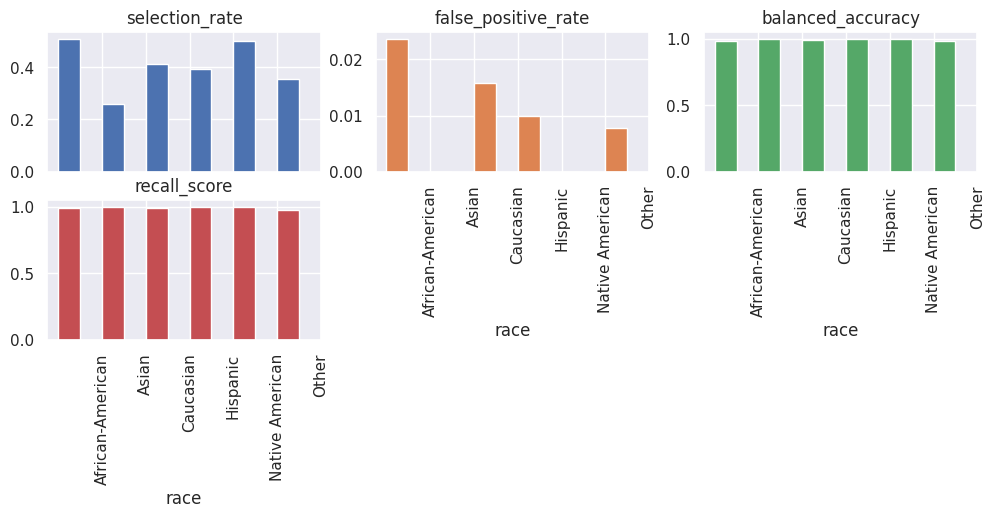

In [ ]:
# You can also easily plot all of the metrics using DataFrame plotting capabilities

metricframe_unmitigated.by_group.plot.bar(subplots=True, layout= [2,3], figsize=(12, 4),
                      legend=False, rot=90, position=2);

According to the above bar chart, it seems that the group *Asian* is selected for the compas program less often than other groups as reflected by the selection rate. Also this group experiences the least false positive rate, so a smaller fraction of group members that are not  likely to recid  are selected. Finally, the balanced accuracy across all groups is similar.



We observe disparity, even though we did not include race in our model. There's a variety of reasons why such disparities may occur. It could be due to representational issues (i.e., not enough instances per group), or because the feature distribution itself differs across groups (i.e., different relationship between features and target variable, obvious example would be people with darker skin in facial recognition systems, but can be much more subtle). Real-world applications often exhibit both kinds of issues at the same time.

<a name="train-other-models"></a>
## Train model: CategoricalNB

In this section, train the CategoricalNB model and evaluate the model using Fairlearn and Aqeuitas for fairness evaluation

1.) First, let's train our machine learning model. We'll create a `HistGradientBoostingClassifier` and fit it to the balanced training data set.

In [ ]:
X_encoded = pd.get_dummies(X, drop_first=True)

# Display the first few rows of the encoded feature set
X_encoded.head()

,age,juv_fel_count,g_decile_score,juv_misd_count,juv_other_count,c_jail_days,c_days_from_compas,is_recid,is_violent_recid,decile_score,...,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,c_charge_degree_M,score_text_Low,score_text_Medium,v_score_text_Low,v_score_text_Medium
0,69,0,1,0,0,1,1,0,0,1,...,False,False,False,False,True,False,True,False,True,False
1,34,0,3,0,0,10,1,1,1,3,...,False,False,False,False,False,False,True,False,True,False
2,24,0,4,0,1,1,1,1,0,4,...,False,False,False,False,False,False,True,False,True,False
3,23,0,8,1,0,0,1,0,0,8,...,False,False,False,False,False,False,False,False,False,True
4,43,0,1,0,0,0,76,0,0,1,...,False,False,False,False,True,False,True,False,True,False


In [ ]:
X_encoded.shape

(7192, 28)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving compas-scores-two-years-clean.csv to compas-scores-two-years-clean.csv


In [ ]:
df = pd.read_csv('compas-scores-two-years-clean.csv')

In [ ]:
df.shape

(7192, 22)

In [ ]:
# data = pd.read_csv('compas-scores-two-years-clean.csv')

# categorical_features = data.select_dtypes(include=['object']).columns
# print(categorical_features)

# for col in categorical_features:
#   df[col] =df[col].astype('category')

# df["c_days_from_compas"] = df["c_days_from_compas"].astype('int64')

# # Drop rows with missing values
# data.dropna(inplace=True)

In [ ]:
df["c_days_from_compas"] = df["c_days_from_compas"].astype('int64')

# Drop rows with missing values
data.dropna(inplace=True)

In [ ]:
categorical_features = df.select_dtypes(include=['object']).columns
print(categorical_features)

for col in categorical_features:
  df[col] =df[col].astype('category')

Index(['sex', 'age_cat', 'race', 'c_charge_degree', 'score_text',
       'v_score_text'],
      dtype='object')


In [ ]:
print(df.columns)

Index(['sex', 'age', 'age_cat', 'race', 'juv_fel_count', 'g_decile_score',
       'juv_misd_count', 'juv_other_count', 'c_jail_days',
       'c_days_from_compas', 'c_charge_degree', 'is_recid', 'is_violent_recid',
       'decile_score', 'score_text', 'v_decile_score', 'v_score_text',
       'priors_count', 'start', 'end', 'event', 'two_year_recid'],
      dtype='object')


In [ ]:
print(df.dtypes)

sex                   category
age                      int64
age_cat               category
race                  category
juv_fel_count            int64
g_decile_score           int64
juv_misd_count           int64
juv_other_count          int64
c_jail_days              int64
c_days_from_compas       int64
c_charge_degree       category
is_recid                 int64
is_violent_recid         int64
decile_score             int64
score_text            category
v_decile_score           int64
v_score_text          category
priors_count             int64
start                    int64
end                      int64
event                    int64
two_year_recid           int64
dtype: object


In [ ]:
df.head(10)

,sex,age,age_cat,race,juv_fel_count,g_decile_score,juv_misd_count,juv_other_count,c_jail_days,c_days_from_compas,...,is_violent_recid,decile_score,score_text,v_decile_score,v_score_text,priors_count,start,end,event,two_year_recid
0,Male,69,Greater than 45,Other,0,1,0,0,1,1,...,0,1,Low,1,Low,0,0,327,0,0
1,Male,34,25 - 45,African-American,0,3,0,0,10,1,...,1,3,Low,1,Low,0,9,159,1,1
2,Male,24,Less than 25,African-American,0,4,0,1,1,1,...,0,4,Low,3,Low,4,0,63,0,1
3,Male,23,Less than 25,African-American,0,8,1,0,0,1,...,0,8,High,6,Medium,1,0,1174,0,0
4,Male,43,25 - 45,Other,0,1,0,0,0,76,...,0,1,Low,1,Low,2,0,1102,0,0
5,Male,44,25 - 45,Other,0,1,0,0,1,0,...,0,1,Low,1,Low,0,1,853,0,0
6,Male,41,25 - 45,Caucasian,0,6,0,0,6,1,...,0,6,Medium,2,Low,14,5,40,1,1
7,Male,43,25 - 45,Other,0,4,0,0,1,1,...,0,4,Low,3,Low,3,0,265,0,0
8,Female,39,25 - 45,Caucasian,0,1,0,0,3,1,...,0,1,Low,1,Low,0,2,747,0,0
9,Male,21,Less than 25,Caucasian,0,3,0,0,1,308,...,1,3,Low,5,Medium,1,0,428,1,1


In [ ]:
data = df

In [ ]:
data.shape

(7192, 22)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Select the features and target variable
features = ['sex', 'age_cat', 'race', 'juv_fel_count', 'juv_misd_count',
            'juv_other_count', 'priors_count', 'c_jail_days', 'is_recid', 'is_violent_recid']
target = 'two_year_recid'

# Split the data into training and testing sets
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Encode categorical features
label_encoders = {}
for col in features:
    if data[col].dtype == 'category':
        le = LabelEncoder()
        # Fit the LabelEncoder on both training and testing data combined
        le.fit(pd.concat([X_train[col], X_test[col]]))
        X_train[col] = le.transform(X_train[col])
        X_test[col] = le.transform(X_test[col])
        label_encoders[col] = le


# Discretize the count features into 5 bins each
count_features = ['juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count',
                  'c_jail_days', 'is_recid', 'is_violent_recid']
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

# Fit and transform the discretizer on the training data only
X_train[count_features] = discretizer.fit_transform(X_train[count_features])

# Transform the test data using the fitted discretizer
X_test[count_features] = discretizer.transform(X_test[count_features])

# Train the CategoricalNB model
model = CategoricalNB()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the evaluation results
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(report)

# Create a metrics dictionary
metrics_dict = {
    "selection_rate": selection_rate,
    "false_positive_rate": false_positive_rate,
    "balanced_accuracy": balanced_accuracy_score,
    "recall_score": recall_score
}

# Create a MetricFrame for the unmitigated model
metricframe_unmitigated = MetricFrame(
    metrics=metrics_dict,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=X_test['race']
)

# Retrieve the disaggregated metrics by group
selection_rate_by_group = metricframe_unmitigated.by_group['selection_rate']
fpr_by_group = metricframe_unmitigated.by_group['false_positive_rate']
balanced_accuracy_by_group = metricframe_unmitigated.by_group['balanced_accuracy']
recall_by_group = metricframe_unmitigated.by_group['recall_score']

# Print the disaggregated metrics
print("Selection Rate by Group")
print(selection_rate_by_group)
print("False Positive Rate by Group")
print(fpr_by_group)
print("Balanced Accuracy by Group")
print(balanced_accuracy_by_group)
print("Recall Score by Group")
print(recall_by_group)

# Calculate and print the differences in metrics
selection_rate_difference = selection_rate_by_group.max() - selection_rate_by_group.min()
fpr_difference = fpr_by_group.max() - fpr_by_group.min()

print("\nDifference in Selection Rate by Group")
print(selection_rate_difference)
print("\nDifference in False Positive Rate by Group")
print(fpr_difference)

Accuracy: 0.9666435024322446
Confusion Matrix:
[[742  48]
 [  0 649]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       790
           1       0.93      1.00      0.96       649

    accuracy                           0.97      1439
   macro avg       0.97      0.97      0.97      1439
weighted avg       0.97      0.97      0.97      1439

Selection Rate by Group
race
0   0.569
1   0.222
2   0.417
3   0.383
5   0.297
Name: selection_rate, dtype: float64
False Positive Rate by Group
race
0   0.096
1   0.000
2   0.031
3   0.033
5   0.037
Name: false_positive_rate, dtype: float64
Balanced Accuracy by Group
race
0   0.952
1   1.000
2   0.984
3   0.983
5   0.981
Name: balanced_accuracy, dtype: float64
Recall Score by Group
race
0   1.000
1   1.000
2   1.000
3   1.000
5   1.000
Name: recall_score, dtype: float64

Difference in Selection Rate by Group
0.34669669669669667

Difference in False Positive Rate by Group
0

In [ ]:
cm = confusion_matrix(Y_test, Y_train)
print(cm)

[[1087  891]
 [ 891  727]]


2.) Next, let's evaluate the fairness of the model using the `MetricFrame`. In the below cells, create a `MetricFrame` that looks at the following metrics:


*   _Count_: The number of data points belonging to each sensitive feature category.
*   _False Positive Rate_: $\dfrac{FN}{FN+TP}$
*  _Recall Score_: $\dfrac{TP}{TP+FN}$

As an extra challenge, you can use the prediction probabilities to compute the _ROC AUC Score_ for each sensitive group pair.



In [ ]:

# from sklearn.naive_bayes import GaussianNB
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, balanced_accuracy_score
# from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate

# # Load your dataframe
# df = pd.read_csv('compas-scores-two-years-clean.csv')

# # Drop rows with missing values
# df.dropna(inplace=True)

# # Define the target variable and sensitive attribute
# target_variable = "two_year_recid"
# sensitive = ["race"]

# # Extract the target variable Y and sensitive attributes A
# Y = df[target_variable]
# A = df[sensitive]

# # Drop the target variable to create the feature set X
# X = df.drop(columns=[target_variable])

# # One-hot encode the categorical features in X
# X_encoded = pd.get_dummies(X, drop_first=True)

# # Split the data into training and testing sets
# X_train, X_test, Y_train, Y_test, A_train, A_test = train_test_split(X_encoded, Y, A, test_size=0.3, random_state=42)

# # Initialize the Naive Bayes model
# nb_model = GaussianNB()

# # Train the model
# nb_model.fit(X_train, Y_train)

# # Make predictions on the test set
# Y_pred = nb_model.predict(X_test)

# # Evaluate the model
# accuracy = accuracy_score(Y_test, Y_pred)
# conf_matrix = confusion_matrix(Y_test, Y_pred)
# class_report = classification_report(Y_test, Y_pred)

# # Print the evaluation results
# print(f"Accuracy: {accuracy}")
# print("Confusion Matrix:")
# print(conf_matrix)
# print("Classification Report:")
# print(class_report)

# # Create a metrics dictionary
# metrics_dict = {
#     "selection_rate": selection_rate,
#     "false_positive_rate": false_positive_rate,
#     "balanced_accuracy": balanced_accuracy_score,
#     "recall_score": recall_score
# }

# # Create a MetricFrame for the unmitigated model
# metricframe_unmitigated = MetricFrame(
#     metrics=metrics_dict,
#     y_true=Y_test,
#     y_pred=Y_pred,
#     sensitive_features=A_test['race']
# )

# # Retrieve the disaggregated metrics by group
# selection_rate_by_group = metricframe_unmitigated.by_group['selection_rate']
# fpr_by_group = metricframe_unmitigated.by_group['false_positive_rate']
# balanced_accuracy_by_group = metricframe_unmitigated.by_group['balanced_accuracy']
# recall_by_group = metricframe_unmitigated.by_group['recall_score']

# # Print the disaggregated metrics
# print("Selection Rate by Group")
# print(selection_rate_by_group)
# print("False Positive Rate by Group")
# print(fpr_by_group)
# print("Balanced Accuracy by Group")
# print(balanced_accuracy_by_group)
# print("Recall Score by Group")
# print(recall_by_group)

# # Calculate and print the differences in metrics
# selection_rate_difference = selection_rate_by_group.max() - selection_rate_by_group.min()
# fpr_difference = fpr_by_group.max() - fpr_by_group.min()

# print("\nDifference in Selection Rate by Group")
# print(selection_rate_difference)
# print("\nDifference in False Positive Rate by Group")
# print(fpr_difference)


Accuracy: 0.9698795180722891
Confusion Matrix:
[[1141   57]
 [   8  952]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1198
           1       0.94      0.99      0.97       960

    accuracy                           0.97      2158
   macro avg       0.97      0.97      0.97      2158
weighted avg       0.97      0.97      0.97      2158

Selection Rate by Group
race
African-American   0.556
Asian              0.091
Caucasian          0.402
Hispanic           0.341
Native American    0.250
Other              0.328
Name: selection_rate, dtype: float64
False Positive Rate by Group
race
African-American   0.079
Asian              0.000
Caucasian          0.020
Hispanic           0.021
Native American    0.000
Other              0.049
Name: false_positive_rate, dtype: float64
Balanced Accuracy by Group
race
African-American   0.959
Asian              0.750
Caucasian          0.990
Hispanic           0.963
Na

## CategoricalNB: Fairness using Fairlearn library

Now, let's create our `MetricFrame` using the metrics listed above with the sensitive groups of `race` and `gender`.

In [ ]:
metricframe_exercise = MetricFrame(
    metrics=false_positive_rate,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=X_test['race']
)

3.) Finally, play around with the plotting capabilities of the `MetricFrame` in the below section.



In [ ]:
metricframe_exercise.by_group

,false_positive_rate
race,
0,0.096
1,0.000
2,0.031
3,0.033
5,0.037


array([[<Axes: title={'center': 'false_positive_rate'}, xlabel='race'>,
        <Axes: xlabel='race'>, <Axes: xlabel='race'>]], dtype=object)

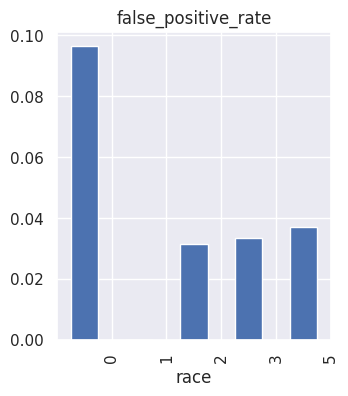

In [ ]:
# Plot some of the performance disparities here
metricframe_exercise.by_group.plot.bar(subplots=True, layout=[1,3], figsize=(12, 4),
                                       legend=False, rot=90, position=1.5)

The charts above are based on test data, so without any uncertainty quantification (such as error bars or confidence intervals), we cannot reliably compare these data statistics. Next section shows how to augment MetricFrame with the report of error bars.

## Adding error bars

In this section, we define new custom metrics that quantify errors in our estimates of selection rate, false negative rate and balanced accuracy, and then review our metrics again.

In [ ]:
# All of our error bar calculations are based on normal approximation to
# the binomial variables.

def error_bar_normal(n_successes, n_trials, z=1.96):
  """
  Computes the error bars for the parameter p of a binomial variable
  using normal approximation. The default value z corresponds to the 95%
  confidence interval.
  """
  point_est = n_successes / n_trials
  error_bar = z*np.sqrt(point_est*(1-point_est))/np.sqrt(n_trials)
  return error_bar

def fpr_error(Y_true, Y_pred):
  """
  Compute the 95%-error bar for the false positive rate
  """
  tn, fp, fn, tp = confusion_matrix(Y_true, Y_pred).ravel()
  return error_bar_normal(fp, tn+fp)

def fnr_error(Y_true, Y_pred):
  """
  Compute the 95%-error bar for the false negative rate
  """
  tn, fp, fn, tp = confusion_matrix(Y_true, Y_pred).ravel()
  return error_bar_normal(fn, fn+tp)

def selection_rate_error(Y_true, Y_pred):
  """
  Compute the 95%-error bar for the selection rate
  """
  tn, fp, fn, tp = confusion_matrix(Y_true, Y_pred).ravel()
  return error_bar_normal(tp+fp, tn+fp+fn+tp)

def balanced_accuracy_error(Y_true, Y_pred):
  """
  Compute the 95%-error bar for the balanced accuracy
  """
  fnr_err, fpr_err = fnr_error(Y_true, Y_pred), fpr_error(Y_true, Y_pred)
  return np.sqrt(fnr_err**2 + fpr_err**2)/2

We next create a metric frame that includes the sample sizes and error bar sizes in addition to the metrics that we have used previously.

In [ ]:
metrics_with_err_bars = {
    "count": count,
    "selection_rate": selection_rate,
    "selection_err_bar": selection_rate_error,
    "false_positive_rate": false_positive_rate,
    "fpr_err_bar": fpr_error,
    "balanced_accuracy": balanced_accuracy_score,
    "bal_acc_err_bar": balanced_accuracy_error
}

# sometimes we will only want to display metrics without error bars
metrics_to_display = [
    "count",
    "selection_rate",
    "false_positive_rate",
    "balanced_accuracy"
]

# sometimes we will only want to show the difference values of the metrics other than count
differences_to_display = [
    "selection_rate",
    "false_positive_rate",
    "balanced_accuracy"
]

In [ ]:
metricframe_unmitigated_w_err = MetricFrame(
    metrics=metrics_with_err_bars,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=X_test['race']
)

In [ ]:
unmitigated_groups = metricframe_unmitigated_w_err.by_group
unmitigated_groups # show both the metrics as well as the error bars

,count,selection_rate,selection_err_bar,false_positive_rate,fpr_err_bar,balanced_accuracy,bal_acc_err_bar
race,,,,,,,
0,740.000,0.569,0.036,0.096,0.031,0.952,0.015
1,9.000,0.222,0.272,0.000,0.000,1.000,0.000
2,475.000,0.417,0.044,0.031,0.020,0.984,0.010
3,141.000,0.383,0.080,0.033,0.037,0.983,0.019
5,74.000,0.297,0.104,0.037,0.050,0.981,0.025


We see that for smaller sample sizes we have larger error bars. The problem is further exacerbated for false negative rate, which is estimated only over *positive examples* and so its sample sizes is further reduced due to label imbalance.

We next visualize the metrics with the corresponding error bars using a custom plotting function.

In [ ]:
def plot_group_metrics_with_error_bars(metricframe, metric, error_name):
  """
  Plots the disaggregated `metric` for each group with an associated
  error bar. Both metric and the erro bar are provided as columns in the
  provided metricframe.
  """
  grouped_metrics = metricframe.by_group
  point_estimates = grouped_metrics[metric]
  error_bars = grouped_metrics[error_name]
  lower_bounds = point_estimates - error_bars
  upper_bounds = point_estimates + error_bars

  x_axis_names = [str(name) for name in error_bars.index.to_flat_index().tolist()]
  plt.vlines(x_axis_names, lower_bounds, upper_bounds, linestyles="dashed", alpha=0.45)
  plt.scatter(x_axis_names, point_estimates, s=25)
  plt.xticks(rotation=0)
  y_start, y_end = np.round(min(lower_bounds), decimals=2), np.round(max(upper_bounds), decimals=2)
  plt.yticks(np.arange(y_start, y_end, 0.05))
  plt.ylabel(metric)

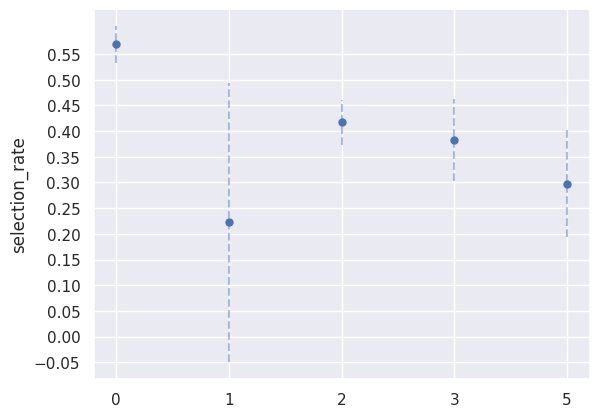

In [ ]:
plot_group_metrics_with_error_bars(metricframe_unmitigated_w_err, "selection_rate", "selection_err_bar")

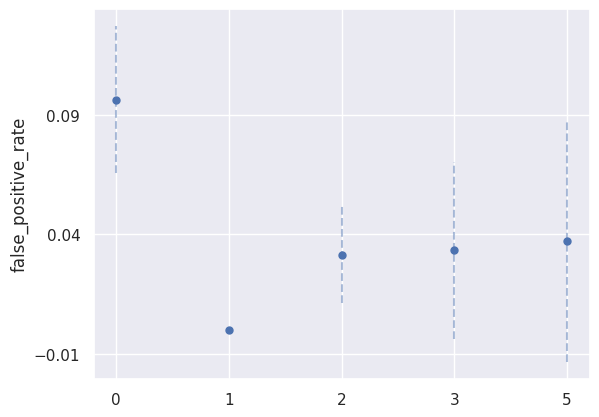

In [ ]:
plot_group_metrics_with_error_bars(metricframe_unmitigated_w_err, "false_positive_rate", "fpr_err_bar")

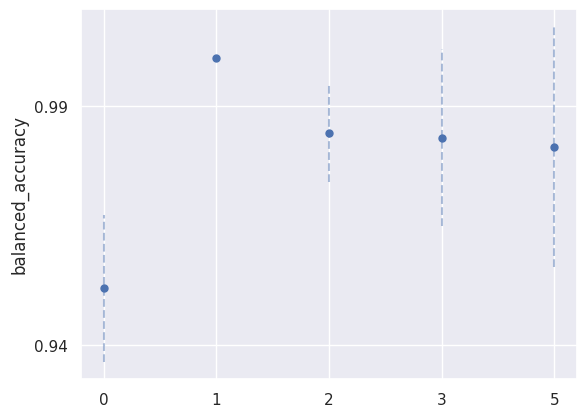

In [ ]:
plot_group_metrics_with_error_bars(metricframe_unmitigated_w_err, "balanced_accuracy", "bal_acc_err_bar")

As we see above, even accounting for the larger uncertainty in estimating the false positive rate for *Other*, this group is experiencing substantially larger false positive rate than other groups and thus experiences the harm of allocation.

CategoricalNB: Fairness using Aequitas library



---


# **Mitigating fairness-related harms in ML models**

We have found that the logistic regression predictor leads to a large difference in false positive rates between the groups. We next look at **algorithmic mitigation strategies** of this fairness issue (and similar ones).

*Note that while we currently focus on the training stage of the AI lifecycle mitigation should not be limited to this stage. In fact, we have already discussed mitigation strategies that are applicable at the task definition stage (e.g., checking for construct validity) and data collection stage (e.g., collecting more data).*

Within the model training stage, mitigation may occur at different steps relative to model training:

* **Preprocessing**: A mitigation algorithm is applied to transform the input data to the training algorithm; for example, some strategies seek to remove and dependence between the input features and sensitive features.

* **At training time**: The model is trained by an (optimization) algorithm that seeks to satisfy fairness constraints.

* **Postprocessing**: The output of a trained model is transformed to mitigate fairness issues; for example, the predicted probability of readmission is thresholded according to a group-specific threshold.

We will now dive into two algorithms: a postprocessing approach and a reductions approach (which is a training-time algorithm). Both of them are in fact **meta-algorithms** in the sense that they act as wrappers around *any* standard (fairness-unaware) machine learning algorithms. This makes them quite versatile in practice.


## Postprocessing with `ThresholdOptimizer`

**Postprocessing** techniques are a class of unfairness-mitigation algorithms that take an already trained model and a dataset as an input and seek to fit a transformation function to model's outputs to satisfy some (group) fairness constraint(s). They might be the only feasible unfairness mitigation approach when developers cannot influence training of the model, due to practical reasons or due to security or privacy.


Here we use the `ThresholdOptimizer` algorithm from Fairlearn, which follows the approach of [Hardt, Price, and Srebro (2016)](https://arxiv.org/abs/1610.02413).

`ThresholdOptimizer` takes in an exisiting (possibly pre-fit) machine learning model whose predictions act as a scoring function and identifies a separate threshold for each group in order to optimize some specified objective metric (such as **balanced accuracy**) subject to specified fairness constraints (such as **false positive rate parity**). Thus, the resulting classifier is just a suitably thresholded version of the underlying machinelearning model.

The constraint **false positive rate parity** requires that all the groups have equal values of false positive rate.



To instatiate our `ThresholdOptimizer`, we pass in:

*   An existing `estimator` that we wish to threshold.
*   The fairness `constraints` we want to satisfy.
*   The `objective` metric we want to maximize.



In [ ]:
# Now we instantite ThresholdOptimizer with the logistic regression estimator
postprocess_est = ThresholdOptimizer(
    estimator=unmitigated_pipeline,
    constraints="false_positive_rate_parity",
    objective="balanced_accuracy_score",
    prefit=True,
    predict_method='predict_proba'
)

In order to use the `ThresholdOptimizer`, we need access to the sensitive features **both during training time and once it's deployed**.

In [ ]:
postprocess_est.fit(X_train_bal, Y_train_bal, sensitive_features=A_train_bal)

ThresholdOptimizer(constraints='false_positive_rate_parity',
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               Index(['age', 'juv_fel_count', 'g_decile_score', 'juv_misd_count',
       'juv_other_count', 'c_jail_days', 'c_days_from_compas', 'is_recid',
       'is_violent_recid', 'decile_score', 'v_decile_score', 'priors_count',
       'start', 'end', 'event'],
      dtype='object')),
                                                                              ('cat',
                                                                               OneHotEncoder(),
                                                                               Index(['sex', 'age_cat', 'race', 'c_charge_degree', 'score_text',
       'v_score_text'],
      dtype='object'))])),
                                             ('logistic_regression',
                                              LogisticRegression(max_iter=1000))]),
                   objective='balanced_accuracy_score',
                   predict_method='predict_proba', prefit=True)

In [ ]:
# Fit the ThresholdOptimizer to your training data
postprocess_est.fit(X_train_bal, Y_train_bal, sensitive_features=A_train_bal)

# Now you can predict using the fitted model
Y_pred_postprocess = postprocess_est.predict(X_test, sensitive_features=A_test)


# Record and evaluate the output of the trained ThresholdOptimizer on test data

# Y_pred_postprocess = postprocess_est.predict(X_test, sensitive_features=A_test)
metricframe_postprocess = MetricFrame(
    metrics=metrics_dict,
    y_true=Y_test,
    y_pred=Y_pred_postprocess,
    sensitive_features=A_test
)

We can now inspect how the metric values differ between the postprocessed model and the unmitigated model:

In [ ]:
pd.concat([metricframe_unmitigated.by_group,
           metricframe_postprocess.by_group],
           keys=['Unmitigated', 'ThresholdOptimizer'],
           axis=1)

Unmitigated                                        \
                 selection_rate false_positive_rate balanced_accuracy   
race                                                                    
0                         0.569               0.096             0.952   
1                         0.222               0.000             1.000   
2                         0.417               0.031             0.984   
3                         0.383               0.033             0.983   
5                         0.297               0.037             0.981   
African-American            NaN                 NaN               NaN   
Asian                       NaN                 NaN               NaN   
Caucasian                   NaN                 NaN               NaN   
Hispanic                    NaN                 NaN               NaN   
Native American             NaN                 NaN               NaN   
Other                       NaN                 NaN               NaN   

                              ThresholdOptimizer                      \
                 recall_score     selection_rate false_positive_rate   
race                                                                   
0                       1.000                NaN                 NaN   
1                       1.000                NaN                 NaN   
2                       1.000                NaN                 NaN   
3                       1.000                NaN                 NaN   
5                       1.000                NaN                 NaN   
African-American          NaN              0.493               0.011   
Asian                     NaN              0.261               0.000   
Caucasian                 NaN              0.410               0.017   
Hispanic                  NaN              0.396               0.015   
Native American           NaN              0.500               0.000   
Other                     NaN              0.358               0.016   

                                                 
                 balanced_accuracy recall_score  
race                                             
0                              NaN          NaN  
1                              NaN          NaN  
2                              NaN          NaN  
3                              NaN          NaN  
5                              NaN          NaN  
African-American             0.981        0.973  
Asian                        1.000        1.000  
Caucasian                    0.985        0.987  
Hispanic                     0.993        1.000  
Native American              1.000        1.000  
Other                        0.978        0.972

We next zoom in on differences between the largest and the smallest metric values:

In [ ]:
pd.concat([metricframe_unmitigated.difference(),
           metricframe_postprocess.difference()],
          keys=['Unmitigated: difference', 'ThresholdOptimizer: difference'],
          axis=1).T

,selection_rate,false_positive_rate,balanced_accuracy,recall_score
Unmitigated: difference,0.347,0.096,0.048,0.000
ThresholdOptimizer: difference,0.239,0.017,0.022,0.028


As we see, `ThresholdOptimizer` was able to substantially decrease the difference between the values of false positive rate.

Finally, we save the disagregated statistics:

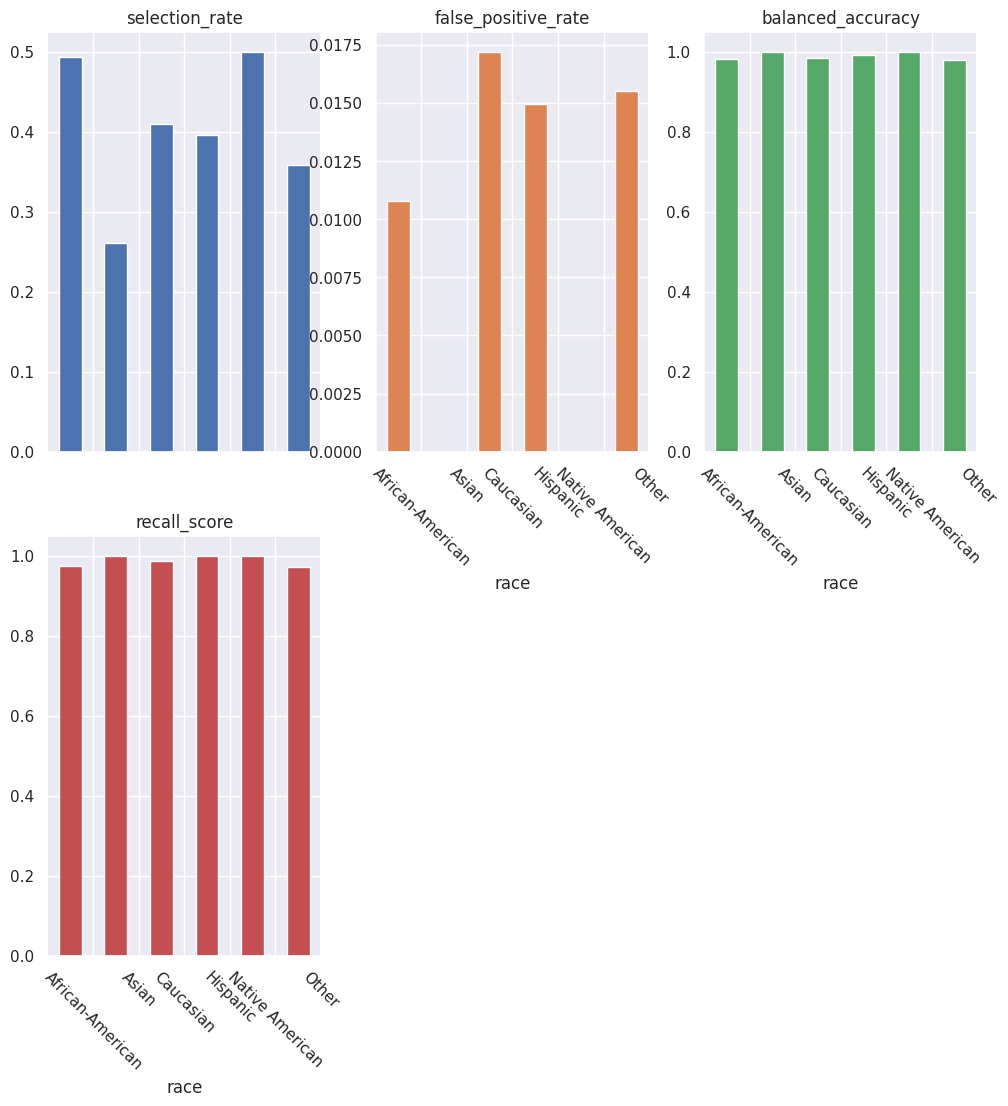

In [ ]:
# Calculate the number of unique groups
num_groups = len(metricframe_postprocess.by_group.index.get_level_values(0).unique())

# Calculate appropriate layout dimensions
nrows = (num_groups + 2) // 3  # Adjust as needed for desired layout
ncols = min(num_groups, 3)

# Plot with adjusted layout
metricframe_postprocess.by_group.plot.bar(
    subplots=True, layout=[nrows, ncols], figsize=(12, 6 * nrows),  # Adjust figsize as needed
    legend=False, rot=-45, position=1.5
)

postprocess_performance = figure_to_base64str(plt)

Next optional section shows that `ThresholdOptimizer` more closely satisfies constraints on the training data than on the test data.

### Postprocessing: Correctness check

We can verify that `ThresholdOptimizer` achieves false positive rate parity on the training dataset, meaning that the values of the false positive rate parity with respect to all groups are close on the training data.

In [ ]:
# Record and evaluate the output of the ThresholdOptimizer on the training data

Y_pred_postprocess_training = postprocess_est.predict(X_train_bal, sensitive_features=A_train_bal)
metricframe_postprocess_training = MetricFrame(
    metrics=metrics_dict,
    y_true=Y_train_bal,
    y_pred=Y_pred_postprocess_training,
    sensitive_features=A_train_bal
)
metricframe_postprocess_training.by_group

,selection_rate,false_positive_rate,balanced_accuracy,recall_score
race,,,,
African-American,0.567,0.017,0.977,0.971
Asian,0.300,0.000,1.000,1.000
Caucasian,0.434,0.015,0.989,0.994
Hispanic,0.410,0.026,0.987,1.000
Native American,0.625,0.000,1.000,1.000
Other,0.397,0.021,0.990,1.000


In [ ]:
# Evaluate the difference between the largest and smallest value of each metric
metricframe_postprocess_training.difference()

selection_rate        0.325
false_positive_rate   0.026
balanced_accuracy     0.023
recall_score          0.029
dtype: float64

The value of `false_positive_rate_difference` on the training data is smaller than on the test data.

When we were describing `ThresholdOptimizer` we said that it picks a separate threshold for each group. However, that is not quite correct. In fact,`ThresholdOptimizer`, for each group, picks two thresholds that are close to each other (say `threshold0` and `threshold1`) and then, at deployment time, randomizes between the two: choosing `threshold0` with some probability `p0` and `threshold1` with the remaining probability `p1=1-p0` (the specific probabilities are determined during training; for certain kinds of constraints, three thresholds are considered.)

This means that the predictions are randomized. To achieve reproducible randomization, it is possible to provide an argument `random_state` to the `predict` method. However, in some settings, even such reproducible randomization is not acceptable and can be in fact viewed as a fairness issue, because of its arbitrariness.

One derandomization heuristic is to replace the two thresholds by their weighted average, i.e., `threshold = p0*threshold0 + p1*threshold1`. That corresponds to the assumption that the values of the scores between the two thresholds are approximately uniformly distributed. Using this heuristic, we derandomize `ThresholdOptimizer`.



In [ ]:
test_dict = {
    "Unmitigated": metricframe_unmitigated,
    "Postprocessing": metricframe_postprocess
}

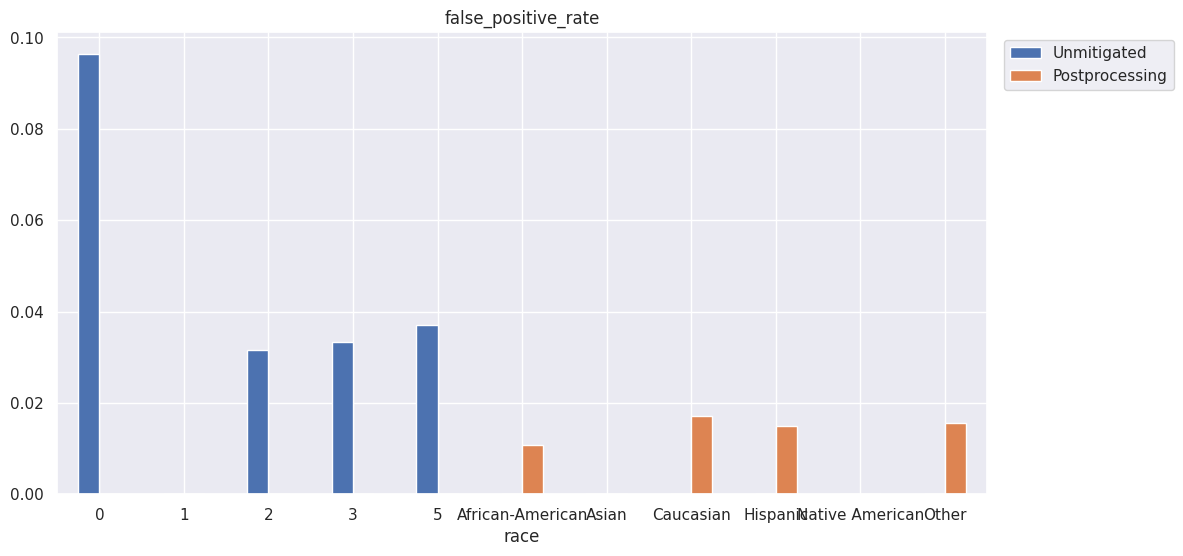

In [ ]:
plot_technique_comparison(test_dict, "false_positive_rate")

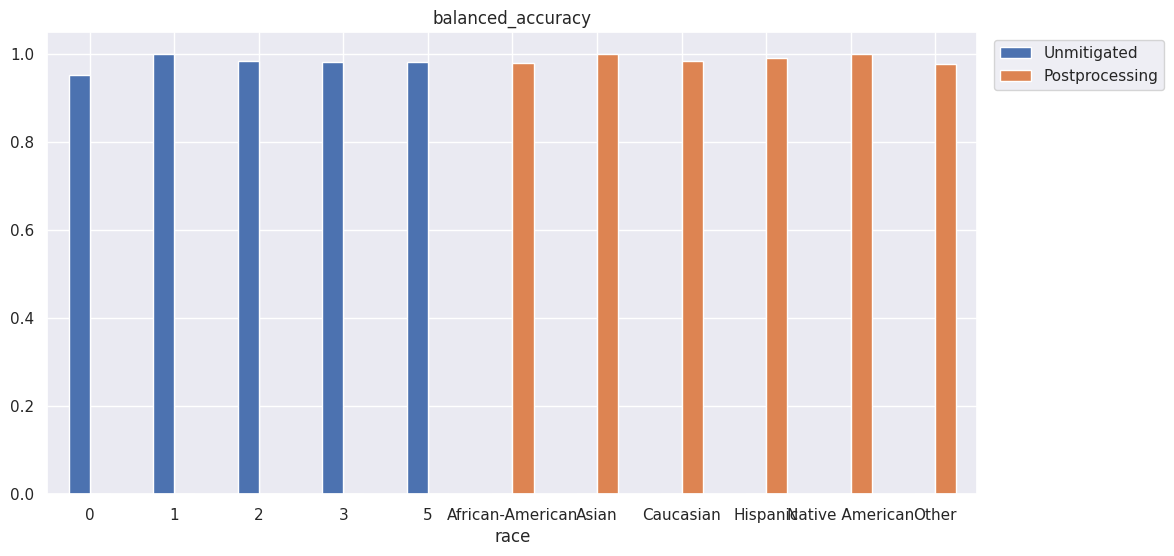

In [ ]:
plot_technique_comparison(test_dict, "balanced_accuracy")

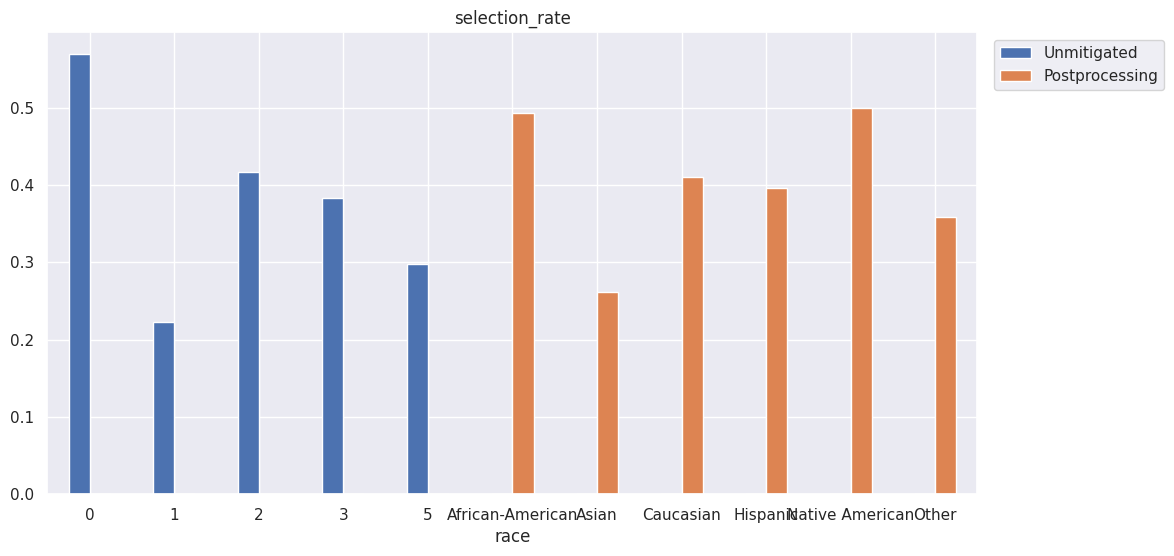

In [ ]:
plot_technique_comparison(test_dict, "selection_rate")



#### Model performance - overall

In [ ]:
overall_df = pd.DataFrame.from_dict({
    "Unmitigated": metricframe_unmitigated.overall,
    "Postprocessing": metricframe_postprocess.overall
})

In [ ]:
overall_df.T

,selection_rate,false_positive_rate,balanced_accuracy,recall_score
Unmitigated,0.484,0.061,0.970,1.000
Postprocessing,0.448,0.014,0.983,0.980


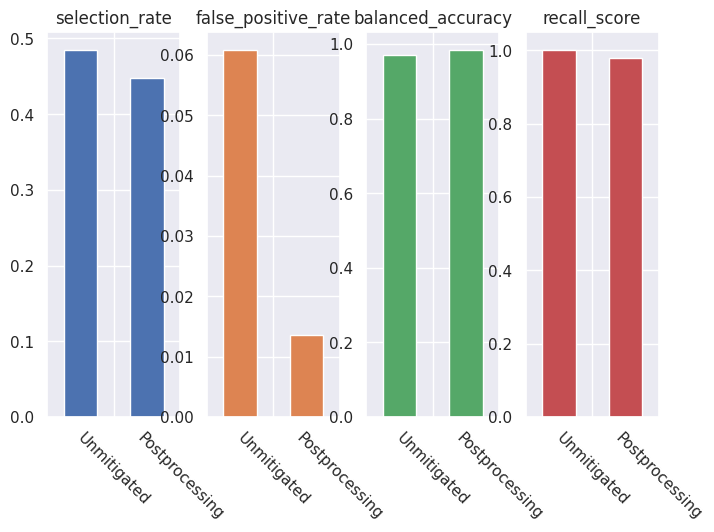

In [ ]:
overall_df.transpose().plot.bar(subplots=True, layout= [1,6], figsize=(12, 5), legend=False, rot=-45, position=1.5);

In [ ]:
difference_df = pd.DataFrame.from_dict({
    "Unmitigated": metricframe_unmitigated.difference(),
    "Postprocessing": metricframe_postprocess.difference()
}
)

In [ ]:
difference_df.T

,selection_rate,false_positive_rate,balanced_accuracy,recall_score
Unmitigated,0.347,0.096,0.048,0.000
Postprocessing,0.239,0.017,0.022,0.028


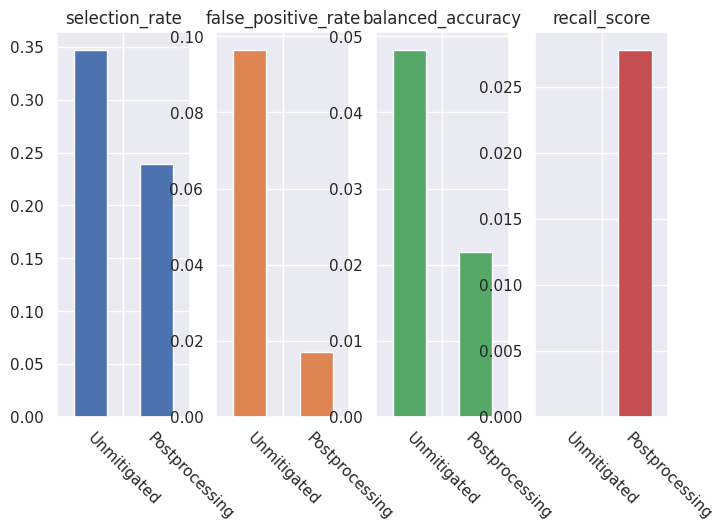

In [ ]:
difference_df.T.plot.bar(subplots=True, layout= [1,6], figsize=(12, 5), legend=False, rot=-45, position=1.5);

### Access to sensitive features





*   The `ThresholdOptimizer` model requires access to the sensitive features during BOTH training time and once deployed. If you do not have access to the sensitive features once the model is deployed, you will not be able to use the `ThresholdOptimizer`.





# Discussion and conclusion

In this study we explored in depth a criminal justice scenario through stages of the AI lifecycle. We have seen how fairness-related harms can arise at the stage of task definition, data collection, model training, and model evaluation. We have also seen how to use a variety of tools, Fairlearn and Aequitas.

Further resources can also be found [on our website](https://fairlearn.org/main/user_guide/further_resources.html).